In [72]:
#Rating and potential prediction system using current rating, potential and stats, combined with statistics from transfermarkt

In [73]:
#Databases used:
#https://www.kaggle.com/stefanoleone992/fifa-20-complete-player-dataset
#https://www.kaggle.com/kriegsmaschine/soccer-players-values-and-their-statistics
#Merging transfermarkt and sofifa databases

In [74]:
import pandas as pd
pd.options.mode.chained_assignment = None #Disabling chained assigment warning 
import numpy as np
import os
from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense, BatchNormalization, Add, GaussianNoise, Dropout
from keras.models import Model
from keras import regularizers
from keras import optimizers
import re
import tensorflow as tf #tensorflow
from tensorflow import keras #keras
from tensorflow.keras import layers #layers
from keras import backend as K #keras backend

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from google.colab import drive #library to read google drive files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [75]:
train_df1 ='/content/gdrive/My Drive/Proyects/fifa_deep_learning/players_18.csv' #training data direction
train_df2 ='/content/gdrive/My Drive/Proyects/fifa_deep_learning/transfermarkt_fbref_201718.xlsx' #training data direction
train_df3 ='/content/gdrive/My Drive/Proyects/fifa_deep_learning/players_19.csv' #training data direction
train_df4 ='/content/gdrive/My Drive/Proyects/fifa_deep_learning/transfermarkt_fbref_201819.xlsx' #training data direction
test_df ='/content/gdrive/My Drive/Proyects/fifa_deep_learning/players_20.csv' #validation data direction
test_df2 ='/content/gdrive/My Drive/Proyects/fifa_deep_learning/transfermarkt_fbref_201920.xlsx' #validation data direction
datos_train1 = pd.read_csv(train_df1) #read training data with pandas
datos_train2 = pd.read_excel(train_df2) #read training data with pandas
datos_train3 = pd.read_csv(train_df3) #read training data with pandas
datos_train4 = pd.read_excel(train_df4) #read training data with pandas
datos_test = pd.read_csv(test_df) #read test data with pandas
datos_test2 = pd.read_excel(test_df2) #read test data with pandas
datos_train1

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,32,1985-02-05,185,80,Portugal,Real Madrid,94,94,95500000,565000,"LW, ST",Right,5,4,5,High/Low,C. Ronaldo,Yes,195800000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2009-07-01,2021.0,LS,7.0,90.0,93.0,82.0,90.0,33.0,80.0,NaN,NaN,NaN,...,63,29,95+1,85,85,95+9,22,31,23,7,11,15,14,11,92+3,92+3,92+3,91+3,92+3,92+3,92+3,91+3,90+3,90+3,90+3,90+3,83+3,83+3,83+3,90+3,66+3,62+3,62+3,62+3,66+3,62+3,53+3,53+3,53+3,62+3
1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,30,1987-06-24,170,72,Argentina,FC Barcelona,93,93,105000000,565000,RW,Left,5,4,4,Medium/Medium,Messi,Yes,215300000.0,"#Dribbler, #FK Specialist, #Acrobat, #Clinical...",RW,10.0,NaN,2004-07-01,2018.0,RW,10.0,89.0,90.0,86.0,96.0,26.0,61.0,NaN,NaN,NaN,...,48,22,93,90,74,96+2,13,28,26,6,11,15,14,8,89+3,89+3,89+3,92+3,93+3,93+3,93+3,92+3,93+3,93+3,93+3,91+3,84+3,84+3,84+3,91+3,62+3,59+3,59+3,59+3,62+3,58+3,46+3,46+3,46+3,58+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar,Neymar da Silva Santos Junior,25,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,94,123000000,280000,LW,Right,5,5,5,High/Medium,Neymar,Yes,236800000.0,"#Speedster, #Dribbler, #Acrobat",LW,10.0,NaN,2017-08-03,2022.0,LW,10.0,92.0,84.0,79.0,95.0,30.0,60.0,NaN,NaN,NaN,...,56,36,90,80,81,92+12,21,24,33,9,9,15,15,11,85+3,85+3,85+3,89+3,89+3,89+3,89+3,89+3,88+3,88+3,88+3,88+3,79+3,79+3,79+3,88+3,64+3,59+3,59+3,59+3,64+3,60+3,47+3,47+3,47+3,60+3
3,167495,https://sofifa.com/player/167495/manuel-neuer/...,M. Neuer,Manuel Neuer,31,1986-03-27,193,92,Germany,FC Bayern München,92,92,61000000,230000,GK,Right,5,4,1,Medium/Medium,Normal,Yes,100700000.0,NaN,GK,1.0,NaN,2011-07-01,2021.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,91.0,90.0,95.0,...,29,30,12,70,47,70,10,10,11,91+2,90,95,91,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,176580,https://sofifa.com/player/176580/luis-suarez/1...,L. Suárez,Luis Alberto Suárez Díaz,30,1987-01-24,182,86,Uruguay,FC Barcelona,92,92,97000000,510000,ST,Right,5,4,4,High/Medium,Normal,Yes,198900000.0,"#Acrobat, #Clinical Finisher",ST,9.0,NaN,2014-07-11,2021.0,LS,9.0,82.0,90.0,79.0,87.0,42.0,81.0,NaN,NaN,NaN,...,78,41,92,84,85,83,30,45,38,27,25,31,33,37,88+4,88+4,88+4,87+4,89+4,89+4,89+4,87+4,87+4,87+4,87+4,86+4,81+4,81+4,81+4,86+4,68+4,66+4,66+4,66+4,68+4,65+4,59+4,59+4,59+4,65+4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17587,237463,https://sofifa.com/player/237463/adam-kelsey/1...,A. Kelsey,Adam Kelsey,17,1999-11-12,188,74,England,Scunthorpe United,46,63,50000,1000,GK,Right,1,2,1,Medium/Medium,Lean,No,119000.0,NaN,RES,41.0,NaN,2017-01-26,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,47.0,49.0,...,16,9,6,26,17,23,9,11,10,46,47,49-5,42-1,48

In [76]:
#Preprocessing Sofifa Data

In [77]:
#Deleting Non-useful columns
no_use_columns = ['player_url','short_name','value_eur', 	'wage_eur','work_rate','body_type','real_face',
                  'release_clause_eur','player_tags','team_position','team_jersey_number',
                  'loaned_from','joined','contract_valid_until','nation_position','nation_jersey_number',
                  'ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb',
                  'ldm','cdm','rdm','rwb','lb','lcb','cb','rcb','rb','player_traits','gk_handling','gk_kicking',
                  'gk_positioning','gk_reflexes','gk_diving','gk_speed','pace','shooting','passing','dribbling',
                  'defending','physic','nationality','club','dob']

datos_train1 = datos_train1.drop(no_use_columns, axis = 1)
datos_test = datos_test.drop(no_use_columns, axis = 1)
datos_train3 = datos_train3.drop(no_use_columns, axis = 1)
datos_train1

,sofifa_id,long_name,age,height_cm,weight_kg,overall,potential,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,20801,Cristiano Ronaldo dos Santos Aveiro,32,185,80,94,94,"LW, ST",Right,5,4,5,85+1,94+1,88+3,83,88,91-1,81,76,77,93,89-2,91-1,89-1,96,63,94+2,95,92,80,92+2,63,29,95+1,85,85,95+9,22,31,23,7,11,15,14,11
1,158023,Lionel Andrés Messi Cuccittini,30,170,72,93,93,RW,Left,5,4,4,77,95,71,88,85,97,89,90,87,95,92,87,90,95,95,85,68,73-1,59,88,48,22,93,90,74,96+2,13,28,26,6,11,15,14,8
2,190871,Neymar da Silva Santos Junior,25,175,68,92,94,LW,Right,5,5,5,75,89,62,81,83,96,81,84,75,95,94+1,90,96,88,82,80+2,61,78-1,53,77,56,36,90,80,81,92+12,21,24,33,9,9,15,15,11
3,167495,Manuel Neuer,31,193,92,92,92,GK,Right,5,4,1,15,13,25,55,11,30,14,11,59,48,58,61,52,85,35,25,78,44,83,16,29,30,12,70,47,70,10,10,11,91+2,90,95,91,89
4,176580,Luis Alberto Suárez Díaz,30,182,86,92,92,ST,Right,5,4,4,77,94,77,83,88,86,86,84,64,91,88,77,86,93,60,87,69,89,80,86,78,41,92,84,85,83,30,45,38,27,25,31,33,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17587,237463,Adam Kelsey,17,188,74,46,63,GK,Right,1,2,1,14,5,10,19,6,12,13,12,21,12,24,32,38,40+10,26,19,31,28,50,7,16,9,6,26,17,23,9,11,10,46,47,49-5,42-1,48
17588,231381,Jordan Young,17,175,71,46,61,ST,Left,1,2,2,28,47,47,42,33,37,32,25,30,41,66,51,60,54,77,42,73,33,32,51,26,16,46,37,58,50,18,17,14,11,15,12,12,11
17589,240404,Jack Keeble,18,172,66,46,56,CB,Right,1,2,2,28,15,43,30,24,29,28,27,27,34,66,60,45,48,48,30,54,52,42,16,40,48,27,28,25,37,40,52,49,5,10,12,12,11
17590,11728,Barry Richardson,47,185,77,46,46,GK,Right,1,2,1,11,11,12,12,12,11,12,11,13,22,25,25,35-3,51+13,44,13,51,32,47,16,44,16,13,17,22,44,14,12,13,39+2,50-1,39+2,50-8,37+4


In [78]:
#Filling NaN values with 0 or droping if in rows, all columns are NaN 
datos_train1 = datos_train1.dropna()
# Numerical imputation for NaN values on datos_train2
datos_train2 = datos_train2.fillna(0)
datos_train3 = datos_train3.dropna()
datos_train4 = datos_train4.dropna()
datos_test = datos_test.dropna()
datos_test2 = datos_test2.dropna()
datos_train2

,Unnamed: 0,player,nationality,position,squad,age,birth_year,value,height,position2,foot,league,games,games_starts,minutes,goals,assists,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,minutes_90s,shots_total,shots_on_target,shots_free_kicks,shots_on_target_pct,shots_total_per90,...,own_goals_against_gkm,psxg_gkm,psnpxg_per_shot_on_target_againstm,psxg_net_gkm,psxg_net_per90_gkm,passes_completed_launched_gkm,passes_launched_gkm,passes_pct_launched_gkm,passes_gkm,passes_throws_gkm,pct_passes_launched_gkm,passes_length_avg_gkm,goal_kicksm,pct_goal_kicks_launchedm,goal_kick_length_avgm,crosses_gkm,crosses_stopped_gkm,crosses_stopped_pct_gkm,def_actions_outside_pen_area_gkm,def_actions_outside_pen_area_per90_gkm,avg_distance_def_actions_gkm,LgRk,MP,W,D,L,GF,GA,GDiff,Pts,Pts/G,xG,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season
0,379,Burgui,es ESP,"FW,MF",Alavés,23,1993,1800000,186,attack - Left Winger,right,La Liga,23,12,1037,1,1,0,0,1,0,0.09,0.09,0.17,0.09,0.17,0.9,0.9,1.7,0.08,0.15,0.23,0.08,0.23,11.5,14,4,1,28.6,1.22,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14,38,15,2,21,40,50,-10,47,1.24,39.0,53.2,-14.2,-0.37,16.819,0,0,0,201718#
1,2530,Raphaël Varane,fr FRA,DF,Real Madrid,24,1993,70000000,191,Defender - Centre-Back,right,La Liga,27,27,2320,0,1,0,0,3,0,0.00,0.04,0.04,0.00,0.04,0.9,0.9,0.9,0.04,0.04,0.07,0.04,0.07,25.8,10,2,0,20.0,0.39,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,38,22,10,6,94,44,50,76,2.00,83.3,45.4,37.9,1.00,66161.000,1,1,0,201718#
2,721,Rubén Duarte,es ESP,DF,Alavés,21,1995,2000000,179,Defender - Left-Back,left,La Liga,24,24,2138,0,2,0,0,9,2,0.00,0.08,0.08,0.00,0.08,0.5,0.5,1.6,0.02,0.07,0.09,0.02,0.09,23.8,8,1,0,12.5,0.34,...,0.0,0.020175,0.000094,0.0,0.0,0.097368,0.322515,0.00883,0.254094,0.014327,0.026433,0.018012,0.093275,0.029064,0.020643,0.087427,0.006433,0.002164,0.011111,0.000292,0.004737,14,38,15,2,21,40,50,-10,47,1.24,39.0,53.2,-14.2,-0.37,16.819,0,0,0,201718#
3,2512,Samuel Umtiti,fr FRA,DF,Barcelona,23,1993,60000000,182,Defender - Centre-Back,left,La Liga,25,24,2189,1,0,0,0,7,0,0.04,0.00,0.04,0.04,0.04,1.1,1.1,0.0,0.05,0.00,0.05,0.05,0.05,24.3,11,6,0,54.5,0.45,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,38,28,9,1,99,29,70,93,2.45,78.3,41.1,37.2,0.98,66603.000,1,0,0,201718#
4,882,Manu Garcí­a,es ESP,MF,Alavés,31,1986,1800000,183,midfield - Defensive Midfield,left,La Liga,30,27,2438,3,0,0,2,9,0,0.11,0.00,0.11,0.11,0.11,3.1,1.6,1.4,0.11,0.05,0.17,0.06,0.11,27.1,26,8,0,30.8,0.96,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14,38,15,2,21,40,50,-10,47,1.24,39.0,53.2,-14.2,-0.37,16.819,0,0,0,201718#
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,1864,Victor Osimhen,ng NGA,"FW,MF",Wolfsburg,18,1998,1000000,186,attack - Centre-Forward,right,Bundesliga,12,3,287,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.1,1.1,0.3,0.37,0.08,0.45,0.37,0.45,3.2,8,2,0,25.0,2.51,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16,34,6,15,13,36

In [79]:
#Integer Encoding of player_positions: Training Set 1
#Will asociate similar positions. Ex: RB and LB
for i in range(len(datos_train1.index)): #Taking best position only
  datos_train1['player_positions'][i] = datos_train1.player_positions[i].split(',',1)[0]

for i in range (len(datos_train1.index)): 
  if datos_train1['player_positions'][i] == 'GK':
    datos_train1['player_positions'][i] = 1
  if datos_train1['player_positions'][i] == 'LB' or datos_train1['player_positions'][i] == 'RB' or datos_train1['player_positions'][i] == 'LWB' or datos_train1['player_positions'][i] == 'RWB':
    datos_train1['player_positions'][i] = 2
  if datos_train1['player_positions'][i] == 'CB':
    datos_train1['player_positions'][i] = 3
  if datos_train1['player_positions'][i] == 'RM' or datos_train1['player_positions'][i] == 'LM':
    datos_train1['player_positions'][i] = 4
  if datos_train1['player_positions'][i] == 'CDM':
    datos_train1['player_positions'][i] = 5
  if datos_train1['player_positions'][i] == 'CM':
    datos_train1['player_positions'][i] = 6
  if datos_train1['player_positions'][i] == 'CAM':
    datos_train1['player_positions'][i] = 7        
  if datos_train1['player_positions'][i] == 'CF':
    datos_train1['player_positions'][i] = 8
  if datos_train1['player_positions'][i] == 'LW' or datos_train1['player_positions'][i] == 'RW':
    datos_train1['player_positions'][i] = 9 
  if datos_train1['player_positions'][i] == 'ST':
    datos_train1['player_positions'][i] = 10       

datos_train1

,sofifa_id,long_name,age,height_cm,weight_kg,overall,potential,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,20801,Cristiano Ronaldo dos Santos Aveiro,32,185,80,94,94,9,Right,5,4,5,85+1,94+1,88+3,83,88,91-1,81,76,77,93,89-2,91-1,89-1,96,63,94+2,95,92,80,92+2,63,29,95+1,85,85,95+9,22,31,23,7,11,15,14,11
1,158023,Lionel Andrés Messi Cuccittini,30,170,72,93,93,9,Left,5,4,4,77,95,71,88,85,97,89,90,87,95,92,87,90,95,95,85,68,73-1,59,88,48,22,93,90,74,96+2,13,28,26,6,11,15,14,8
2,190871,Neymar da Silva Santos Junior,25,175,68,92,94,9,Right,5,5,5,75,89,62,81,83,96,81,84,75,95,94+1,90,96,88,82,80+2,61,78-1,53,77,56,36,90,80,81,92+12,21,24,33,9,9,15,15,11
3,167495,Manuel Neuer,31,193,92,92,92,1,Right,5,4,1,15,13,25,55,11,30,14,11,59,48,58,61,52,85,35,25,78,44,83,16,29,30,12,70,47,70,10,10,11,91+2,90,95,91,89
4,176580,Luis Alberto Suárez Díaz,30,182,86,92,92,10,Right,5,4,4,77,94,77,83,88,86,86,84,64,91,88,77,86,93,60,87,69,89,80,86,78,41,92,84,85,83,30,45,38,27,25,31,33,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17587,237463,Adam Kelsey,17,188,74,46,63,1,Right,1,2,1,14,5,10,19,6,12,13,12,21,12,24,32,38,40+10,26,19,31,28,50,7,16,9,6,26,17,23,9,11,10,46,47,49-5,42-1,48
17588,231381,Jordan Young,17,175,71,46,61,10,Left,1,2,2,28,47,47,42,33,37,32,25,30,41,66,51,60,54,77,42,73,33,32,51,26,16,46,37,58,50,18,17,14,11,15,12,12,11
17589,240404,Jack Keeble,18,172,66,46,56,3,Right,1,2,2,28,15,43,30,24,29,28,27,27,34,66,60,45,48,48,30,54,52,42,16,40,48,27,28,25,37,40,52,49,5,10,12,12,11
17590,11728,Barry Richardson,47,185,77,46,46,1,Right,1,2,1,11,11,12,12,12,11,12,11,13,22,25,25,35-3,51+13,44,13,51,32,47,16,44,16,13,17,22,44,14,12,13,39+2,50-1,39+2,50-8,37+4


In [80]:
#Integer Encoding of player_positions: Training Set 2
#Will asociate similar positions. Ex: RB and LB
for i in range(len(datos_train3.index)): #Taking best position only
  datos_train3['player_positions'][i] = datos_train3.player_positions[i].split(',',1)[0]

for i in range (len(datos_train3.index)): 
  if datos_train3['player_positions'][i] == 'GK':
    datos_train3['player_positions'][i] = 1
  if datos_train3['player_positions'][i] == 'LB' or datos_train3['player_positions'][i] == 'RB' or datos_train3['player_positions'][i] == 'LWB' or datos_train3['player_positions'][i] == 'RWB':
    datos_train3['player_positions'][i] = 2
  if datos_train3['player_positions'][i] == 'CB':
    datos_train3['player_positions'][i] = 3
  if datos_train3['player_positions'][i] == 'RM' or datos_train3['player_positions'][i] == 'LM':
    datos_train3['player_positions'][i] = 4
  if datos_train3['player_positions'][i] == 'CDM':
    datos_train3['player_positions'][i] = 5
  if datos_train3['player_positions'][i] == 'CM':
    datos_train3['player_positions'][i] = 6
  if datos_train3['player_positions'][i] == 'CAM':
    datos_train3['player_positions'][i] = 7        
  if datos_train3['player_positions'][i] == 'CF':
    datos_train3['player_positions'][i] = 8
  if datos_train3['player_positions'][i] == 'LW' or datos_train3['player_positions'][i] == 'RW':
    datos_train3['player_positions'][i] = 9 
  if datos_train3['player_positions'][i] == 'ST':
    datos_train3['player_positions'][i] = 10       

datos_train3

,sofifa_id,long_name,age,height_cm,weight_kg,overall,potential,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,20801,Cristiano Ronaldo dos Santos Aveiro,33,187,83,94,94,10,Right,5,4,5,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11
1,158023,Lionel Andrés Messi Cuccittini,31,170,72,94,94,8,Left,5,4,4,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8
2,190871,Neymar da Silva Santos Junior,26,175,68,92,93,9,Right,5,5,5,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11
3,193080,David De Gea Quintana,27,193,76,91,93,1,Right,4,3,1,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94
4,192985,Kevin De Bruyne,27,181,70,91,92,7,Right,4,5,4,93,83,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,60,87,94,79,88,67,58,51,15,13,5,10,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17765,238985,Pierce Phillips,19,180,72,47,61,6,Right,1,3,2,31,26,49,55,31,44,30,31,50,41,55,49,51,53,65,46,60,44,49,28,51,49,31,51,40,35,41,44,53,11,6,13,11,8
17766,240160,Alexander Kaltner,18,178,75,47,61,10,Right,1,3,2,37,48,30,45,43,50,41,38,30,51,62,66,67,39,70,38,81,55,60,35,28,25,43,41,48,37,28,15,22,15,5,14,12,8
17767,241304,马俊亮,20,181,64,47,61,6,Right,1,3,2,40,27,45,58,35,46,39,37,47,42,84,78,78,45,70,48,59,58,45,35,58,41,48,40,36,39,54,37,40,5,12,14,14,11
17768,240158,Christoph Ehlich,19,179,73,47,59,2,Right,1,3,2,39,40,45,46,42,46,35,29,22,49,65,62,68,44,70,44,69,61,59,41,38,36,44,38,47,47,40,42,42,13,12,11,15,12


In [81]:
#Integer Encoding of player_positions: Test Set
#Will asociate similar positions. Ex: RB and LB
for i in range(len(datos_test.index)): #Taking best position only
  datos_test['player_positions'][i] = datos_test.player_positions[i].split(',',1)[0]

for i in range (len(datos_test.index)): 
  if datos_test['player_positions'][i] == 'GK':
    datos_test['player_positions'][i] = 1
  if datos_test['player_positions'][i] == 'LB' or datos_test['player_positions'][i] == 'RB' or datos_test['player_positions'][i] == 'LWB' or datos_test['player_positions'][i] == 'RWB':
    datos_test['player_positions'][i] = 2
  if datos_test['player_positions'][i] == 'CB':
    datos_test['player_positions'][i] = 3
  if datos_test['player_positions'][i] == 'RM' or datos_test['player_positions'][i] == 'LM':
    datos_test['player_positions'][i] = 4
  if datos_test['player_positions'][i] == 'CDM':
    datos_test['player_positions'][i] = 5
  if datos_test['player_positions'][i] == 'CM':
    datos_test['player_positions'][i] = 6
  if datos_test['player_positions'][i] == 'CAM':
    datos_test['player_positions'][i] = 7        
  if datos_test['player_positions'][i] == 'CF':
    datos_test['player_positions'][i] = 8
  if datos_test['player_positions'][i] == 'LW' or datos_test['player_positions'][i] == 'RW':
    datos_test['player_positions'][i] = 9 
  if datos_test['player_positions'][i] == 'ST':
    datos_test['player_positions'][i] = 10       

datos_test

,sofifa_id,long_name,age,height_cm,weight_kg,overall,potential,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,158023,Lionel Andrés Messi Cuccittini,32,170,72,94,94,9,Left,5,4,4,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8
1,20801,Cristiano Ronaldo dos Santos Aveiro,34,187,83,93,93,10,Right,5,4,5,84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11
2,190871,Neymar da Silva Santos Junior,27,175,68,92,92,9,Right,5,5,5,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11
3,200389,Jan Oblak,26,188,87,91,93,1,Right,3,3,1,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89
4,183277,Eden Hazard,28,175,74,91,91,9,Right,4,4,4,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18273,245006,邵帅,22,186,79,48,56,3,Right,1,3,2,21,17,40,35,27,24,23,21,28,35,56,58,45,40,73,36,70,60,47,16,46,48,28,25,39,41,45,50,52,5,5,13,5,14
18274,250995,Mingjie Xiao,22,177,66,48,56,3,Right,1,2,2,24,20,42,43,28,32,24,29,39,31,55,61,43,41,76,33,72,55,44,20,42,49,23,25,37,35,42,53,57,13,6,14,11,9
18275,252332,张威,19,186,75,48,56,6,Right,1,2,2,32,33,49,53,32,40,32,32,55,49,55,54,52,52,57,48,60,50,51,26,50,45,38,38,36,39,46,52,46,7,8,10,6,14
18276,251110,汪海健,18,185,74,48,54,6,Right,1,2,2,39,34,47,54,28,42,37,39,48,49,55,63,55,54,59,46,61,42,55,28,57,49,31,48,36,40,39,44,54,14,9,13,13,13


In [82]:
#Normalizing values of overall and potential
#Training Set 1,2 and Test Set

datos_train1['overall'] = datos_train1['overall'].div(100)
datos_train3['overall'] = datos_train3['overall'].div(100)
datos_test['overall'] = datos_test['overall'].div(100)
datos_train1['potential'] = datos_train1['potential'].div(100)
datos_train3['potential'] = datos_train3['potential'].div(100)
datos_test['potential'] = datos_test['potential'].div(100)

In [83]:
#One Hot Encoding of preferred_foot: Training Set 1

datos_train1['right_foot'] = np.zeros
datos_train1['left_foot'] = np.zeros

for i in range (len(datos_train1.index)): 
  if datos_train1['preferred_foot'][i] == 'Left':
    datos_train1['left_foot'][i] = 1
    datos_train1['right_foot'][i] = 0
  if datos_train1['preferred_foot'][i] == 'Right':
    datos_train1['right_foot'][i] = 1
    datos_train1['left_foot'][i] = 0

datos_train1 = datos_train1.drop('preferred_foot', axis = 1)
datos_train1    

,sofifa_id,long_name,age,height_cm,weight_kg,overall,potential,player_positions,international_reputation,weak_foot,skill_moves,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,right_foot,left_foot
0,20801,Cristiano Ronaldo dos Santos Aveiro,32,185,80,0.94,0.94,9,5,4,5,85+1,94+1,88+3,83,88,91-1,81,76,77,93,89-2,91-1,89-1,96,63,94+2,95,92,80,92+2,63,29,95+1,85,85,95+9,22,31,23,7,11,15,14,11,1,0
1,158023,Lionel Andrés Messi Cuccittini,30,170,72,0.93,0.93,9,5,4,4,77,95,71,88,85,97,89,90,87,95,92,87,90,95,95,85,68,73-1,59,88,48,22,93,90,74,96+2,13,28,26,6,11,15,14,8,0,1
2,190871,Neymar da Silva Santos Junior,25,175,68,0.92,0.94,9,5,5,5,75,89,62,81,83,96,81,84,75,95,94+1,90,96,88,82,80+2,61,78-1,53,77,56,36,90,80,81,92+12,21,24,33,9,9,15,15,11,1,0
3,167495,Manuel Neuer,31,193,92,0.92,0.92,1,5,4,1,15,13,25,55,11,30,14,11,59,48,58,61,52,85,35,25,78,44,83,16,29,30,12,70,47,70,10,10,11,91+2,90,95,91,89,1,0
4,176580,Luis Alberto Suárez Díaz,30,182,86,0.92,0.92,10,5,4,4,77,94,77,83,88,86,86,84,64,91,88,77,86,93,60,87,69,89,80,86,78,41,92,84,85,83,30,45,38,27,25,31,33,37,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17587,237463,Adam Kelsey,17,188,74,0.46,0.63,1,1,2,1,14,5,10,19,6,12,13,12,21,12,24,32,38,40+10,26,19,31,28,50,7,16,9,6,26,17,23,9,11,10,46,47,49-5,42-1,48,1,0
17588,231381,Jordan Young,17,175,71,0.46,0.61,10,1,2,2,28,47,47,42,33,37,32,25,30,41,66,51,60,54,77,42,73,33,32,51,26,16,46,37,58,50,18,17,14,11,15,12,12,11,0,1
17589,240404,Jack Keeble,18,172,66,0.46,0.56,3,1,2,2,28,15,43,30,24,29,28,27,27,34,66,60,45,48,48,30,54,52,42,16,40,48,27,28,25,37,40,52,49,5,10,12,12,11,1,0
17590,11728,Barry Richardson,47,185,77,0.46,0.46,1,1,2,1,11,11,12,12,12,11,12,11,13,22,25,25,35-3,51+13,44,13,51,32,47,16,44,16,13,17,22,44,14,12,13,39+2,50-1,39+2,50-8,37+4,1,0


In [84]:
#One Hot Encoding of preferred_foot: Training Set 2

datos_train3['right_foot'] = np.zeros
datos_train3['left_foot'] = np.zeros

for i in range (len(datos_train3.index)): 
  if datos_train3['preferred_foot'][i] == 'Left':
    datos_train3['left_foot'][i] = 1
    datos_train3['right_foot'][i] = 0
  if datos_train3['preferred_foot'][i] == 'Right':
    datos_train3['right_foot'][i] = 1
    datos_train3['left_foot'][i] = 0

datos_train3 = datos_train3.drop('preferred_foot', axis = 1)
datos_train3   

,sofifa_id,long_name,age,height_cm,weight_kg,overall,potential,player_positions,international_reputation,weak_foot,skill_moves,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,right_foot,left_foot
0,20801,Cristiano Ronaldo dos Santos Aveiro,33,187,83,0.94,0.94,10,5,4,5,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,1,0
1,158023,Lionel Andrés Messi Cuccittini,31,170,72,0.94,0.94,8,5,4,4,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,0,1
2,190871,Neymar da Silva Santos Junior,26,175,68,0.92,0.93,9,5,5,5,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,1,0
3,193080,David De Gea Quintana,27,193,76,0.91,0.93,1,4,3,1,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,1,0
4,192985,Kevin De Bruyne,27,181,70,0.91,0.92,7,4,5,4,93,83,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,60,87,94,79,88,67,58,51,15,13,5,10,13,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17765,238985,Pierce Phillips,19,180,72,0.47,0.61,6,1,3,2,31,26,49,55,31,44,30,31,50,41,55,49,51,53,65,46,60,44,49,28,51,49,31,51,40,35,41,44,53,11,6,13,11,8,1,0
17766,240160,Alexander Kaltner,18,178,75,0.47,0.61,10,1,3,2,37,48,30,45,43,50,41,38,30,51,62,66,67,39,70,38,81,55,60,35,28,25,43,41,48,37,28,15,22,15,5,14,12,8,1,0
17767,241304,马俊亮,20,181,64,0.47,0.61,6,1,3,2,40,27,45,58,35,46,39,37,47,42,84,78,78,45,70,48,59,58,45,35,58,41,48,40,36,39,54,37,40,5,12,14,14,11,1,0
17768,240158,Christoph Ehlich,19,179,73,0.47,0.59,2,1,3,2,39,40,45,46,42,46,35,29,22,49,65,62,68,44,70,44,69,61,59,41,38,36,44,38,47,47,40,42,42,13,12,11,15,12,1,0


In [85]:
#One Hot Encoding of preferred_foot: Test Set

datos_test['right_foot'] = np.zeros
datos_test['left_foot'] = np.zeros

for i in range (len(datos_test.index)): 
  if datos_test['preferred_foot'][i] == 'Left':
    datos_test['left_foot'][i] = 1
    datos_test['right_foot'][i] = 0
  if datos_test['preferred_foot'][i] == 'Right':
    datos_test['right_foot'][i] = 1
    datos_test['left_foot'][i] = 0

datos_test = datos_test.drop('preferred_foot', axis = 1)
datos_test  

,sofifa_id,long_name,age,height_cm,weight_kg,overall,potential,player_positions,international_reputation,weak_foot,skill_moves,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,right_foot,left_foot
0,158023,Lionel Andrés Messi Cuccittini,32,170,72,0.94,0.94,9,5,4,4,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,0,1
1,20801,Cristiano Ronaldo dos Santos Aveiro,34,187,83,0.93,0.93,10,5,4,5,84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,1,0
2,190871,Neymar da Silva Santos Junior,27,175,68,0.92,0.92,9,5,5,5,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,1,0
3,200389,Jan Oblak,26,188,87,0.91,0.93,1,3,3,1,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89,1,0
4,183277,Eden Hazard,28,175,74,0.91,0.91,9,4,4,4,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18273,245006,邵帅,22,186,79,0.48,0.56,3,1,3,2,21,17,40,35,27,24,23,21,28,35,56,58,45,40,73,36,70,60,47,16,46,48,28,25,39,41,45,50,52,5,5,13,5,14,1,0
18274,250995,Mingjie Xiao,22,177,66,0.48,0.56,3,1,2,2,24,20,42,43,28,32,24,29,39,31,55,61,43,41,76,33,72,55,44,20,42,49,23,25,37,35,42,53,57,13,6,14,11,9,1,0
18275,252332,张威,19,186,75,0.48,0.56,6,1,2,2,32,33,49,53,32,40,32,32,55,49,55,54,52,52,57,48,60,50,51,26,50,45,38,38,36,39,46,52,46,7,8,10,6,14,1,0
18276,251110,汪海健,18,185,74,0.48,0.54,6,1,2,2,39,34,47,54,28,42,37,39,48,49,55,63,55,54,59,46,61,42,55,28,57,49,31,48,36,40,39,44,54,14,9,13,13,13,1,0


In [86]:
#League Division by clubs
#If player is in 1st division, league_division is 1, 2nd division is 2 and so on
#Not implemented yet

In [87]:
# Removing all +values in the stats, by transforming to str, taking the first 2 digits
# Training Set 1
for i in range(len(datos_train1.index)):
  datos_train1['attacking_crossing'][i] = datos_train1.attacking_crossing[i].split('-',1)[0].split('+',1)[0]
  datos_train1['attacking_finishing'][i] = datos_train1.attacking_finishing[i].split('-',1)[0].split('+',1)[0]
  datos_train1['attacking_heading_accuracy'][i] = datos_train1.attacking_heading_accuracy[i].split('-',1)[0].split('+',1)[0]
  datos_train1['attacking_short_passing'][i] = datos_train1.attacking_short_passing[i].split('-',1)[0].split('+',1)[0]
  datos_train1['attacking_volleys'][i] = datos_train1.attacking_volleys[i].split('-',1)[0].split('+',1)[0]
  datos_train1['skill_dribbling'][i] = datos_train1.skill_dribbling[i].split('-',1)[0].split('+',1)[0]
  datos_train1['skill_curve'][i] = datos_train1.skill_curve[i].split('-',1)[0].split('+',1)[0]
  datos_train1['skill_fk_accuracy'][i] = datos_train1.skill_fk_accuracy[i].split('-',1)[0].split('+',1)[0]
  datos_train1['skill_long_passing'][i] = datos_train1.skill_long_passing[i].split('-',1)[0].split('+',1)[0]
  datos_train1['skill_ball_control'][i] = datos_train1.skill_ball_control[i].split('-',1)[0].split('+',1)[0]
  datos_train1['movement_acceleration'][i] = datos_train1.movement_acceleration[i].split('-',1)[0].split('+',1)[0]
  datos_train1['movement_sprint_speed'][i] = datos_train1.movement_sprint_speed[i].split('-',1)[0].split('+',1)[0]
  datos_train1['movement_agility'][i] = datos_train1.movement_agility[i].split('-',1)[0].split('+',1)[0]
  datos_train1['movement_reactions'][i] = datos_train1.movement_reactions[i].split('-',1)[0].split('+',1)[0]
  datos_train1['movement_balance'][i] = datos_train1.movement_balance[i].split('-',1)[0].split('+',1)[0]
  datos_train1['power_shot_power'][i] = datos_train1.power_shot_power[i].split('-',1)[0].split('+',1)[0]
  datos_train1['power_jumping'][i] = datos_train1.power_jumping[i].split('-',1)[0].split('+',1)[0]
  datos_train1['power_stamina'][i] = datos_train1.power_stamina[i].split('-',1)[0].split('+',1)[0]
  datos_train1['power_strength'][i] = datos_train1.power_strength[i].split('-',1)[0].split('+',1)[0]
  datos_train1['power_long_shots'][i] = datos_train1.power_long_shots[i].split('-',1)[0].split('+',1)[0]
  datos_train1['mentality_aggression'][i] = datos_train1.mentality_aggression[i].split('-',1)[0].split('+',1)[0]
  datos_train1['mentality_interceptions'][i] = datos_train1.mentality_interceptions[i].split('-',1)[0].split('+',1)[0]
  datos_train1['mentality_positioning'][i] = datos_train1.mentality_positioning[i].split('-',1)[0].split('+',1)[0]
  datos_train1['mentality_vision'][i] = datos_train1.mentality_vision[i].split('-',1)[0].split('+',1)[0]
  datos_train1['mentality_penalties'][i] = datos_train1.mentality_penalties[i].split('-',1)[0].split('+',1)[0]
  datos_train1['mentality_composure'][i] = datos_train1.mentality_composure.astype(str)[i].split('-',1)[0].split('+',1)[0]
  datos_train1['defending_marking'][i] = datos_train1.defending_marking[i].split('-',1)[0].split('+',1)[0]
  datos_train1['defending_standing_tackle'][i] = datos_train1.defending_standing_tackle[i].split('-',1)[0].split('+',1)[0]
  datos_train1['defending_sliding_tackle'][i] = datos_train1.defending_sliding_tackle[i].split('-',1)[0].split('+',1)[0]
  datos_train1['goalkeeping_diving'][i] = datos_train1.goalkeeping_diving[i].split('-',1)[0].split('+',1)[0]
  datos_train1['goalkeeping_handling'][i] = datos_train1.goalkeeping_handling[i].split('-',1)[0].split('+',1)[0]
  datos_train1['goalkeeping_kicking'][i] = datos_train1.goalkeeping_kicking[i].split('-',1)[0].split('+',1)[0]
  datos_train1['goalkeeping_positioning'][i] = datos_train1.goalkeeping_positioning[i].split('-',1)[0].split('+',1)[0]
  datos_train1['goalkeeping_reflexes'][i] = datos_train1.goalkeeping_reflexes[i].split('-',1)[0].split('+',1)[0]

In [88]:
# Normalizing all sofifa attributes of players
# Training Set 1 
datos_train1['attacking_crossing'] = datos_train1['attacking_crossing'].astype('int32').div(100)
datos_train1['attacking_finishing'] = datos_train1['attacking_finishing'].astype('int32').div(100)
datos_train1['attacking_heading_accuracy'] = datos_train1['attacking_heading_accuracy'].astype('int32').div(100)
datos_train1['attacking_short_passing'] = datos_train1['attacking_short_passing'].astype('int32').div(100)
datos_train1['attacking_volleys'] = datos_train1['attacking_volleys'].astype('int32').div(100)
datos_train1['skill_dribbling'] = datos_train1['skill_dribbling'].astype('int32').div(100)
datos_train1['skill_curve'] = datos_train1['skill_curve'].astype('int32').div(100)
datos_train1['skill_fk_accuracy'] = datos_train1['skill_fk_accuracy'].astype('int32').div(100)
datos_train1['skill_long_passing'] = datos_train1['skill_long_passing'].astype('int32').div(100)
datos_train1['skill_ball_control'] = datos_train1['skill_ball_control'].astype('int32').div(100)
datos_train1['movement_acceleration'] = datos_train1['movement_acceleration'].astype('int32').div(100)
datos_train1['movement_sprint_speed'] = datos_train1['movement_sprint_speed'].astype('int32').div(100)
datos_train1['movement_agility'] = datos_train1['movement_agility'].astype('int32').div(100)
datos_train1['movement_reactions'] = datos_train1['movement_reactions'].astype('int32').div(100)
datos_train1['movement_balance'] = datos_train1['movement_balance'].astype('int32').div(100)
datos_train1['power_shot_power'] = datos_train1['power_shot_power'].astype('int32').div(100)
datos_train1['power_jumping'] = datos_train1['power_jumping'].astype('int32').div(100)
datos_train1['power_stamina'] = datos_train1['power_stamina'].astype('int32').div(100)
datos_train1['power_strength'] = datos_train1['power_strength'].astype('int32').div(100)
datos_train1['power_long_shots'] = datos_train1['power_long_shots'].astype('int32').div(100)
datos_train1['mentality_aggression'] = datos_train1['mentality_aggression'].astype('int32').div(100)
datos_train1['mentality_interceptions'] = datos_train1['mentality_interceptions'].astype('int32').div(100)
datos_train1['mentality_positioning'] = datos_train1['mentality_positioning'].astype('int32').div(100)
datos_train1['mentality_vision'] = datos_train1['mentality_vision'].astype('int32').div(100)
datos_train1['mentality_penalties'] = datos_train1['mentality_penalties'].astype('int32').div(100)
datos_train1['mentality_composure'] = datos_train1['mentality_composure'].astype('int32').div(100)
datos_train1['defending_marking'] = datos_train1['defending_marking'].astype('int32').div(100)
datos_train1['defending_standing_tackle'] = datos_train1['defending_standing_tackle'].astype('int32').div(100)
datos_train1['defending_sliding_tackle'] = datos_train1['defending_sliding_tackle'].astype('int32').div(100)
datos_train1['goalkeeping_diving'] = datos_train1['goalkeeping_diving'].astype('int32').div(100)
datos_train1['goalkeeping_handling'] = datos_train1['goalkeeping_handling'].astype('int32').div(100)
datos_train1['goalkeeping_kicking'] = datos_train1['goalkeeping_kicking'].astype('int32').div(100)
datos_train1['goalkeeping_positioning'] = datos_train1['goalkeeping_positioning'].astype('int32').div(100)
datos_train1['goalkeeping_reflexes'] = datos_train1['goalkeeping_reflexes'].astype('int32').div(100)
datos_train1

,sofifa_id,long_name,age,height_cm,weight_kg,overall,potential,player_positions,international_reputation,weak_foot,skill_moves,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,right_foot,left_foot
0,20801,Cristiano Ronaldo dos Santos Aveiro,32,185,80,0.94,0.94,9,5,4,5,0.85,0.94,0.88,0.83,0.88,0.91,0.81,0.76,0.77,0.93,0.89,0.91,0.89,0.96,0.63,0.94,0.95,0.92,0.80,0.92,0.63,0.29,0.95,0.85,0.85,0.95,0.22,0.31,0.23,0.07,0.11,0.15,0.14,0.11,1,0
1,158023,Lionel Andrés Messi Cuccittini,30,170,72,0.93,0.93,9,5,4,4,0.77,0.95,0.71,0.88,0.85,0.97,0.89,0.90,0.87,0.95,0.92,0.87,0.90,0.95,0.95,0.85,0.68,0.73,0.59,0.88,0.48,0.22,0.93,0.90,0.74,0.96,0.13,0.28,0.26,0.06,0.11,0.15,0.14,0.08,0,1
2,190871,Neymar da Silva Santos Junior,25,175,68,0.92,0.94,9,5,5,5,0.75,0.89,0.62,0.81,0.83,0.96,0.81,0.84,0.75,0.95,0.94,0.90,0.96,0.88,0.82,0.80,0.61,0.78,0.53,0.77,0.56,0.36,0.90,0.80,0.81,0.92,0.21,0.24,0.33,0.09,0.09,0.15,0.15,0.11,1,0
3,167495,Manuel Neuer,31,193,92,0.92,0.92,1,5,4,1,0.15,0.13,0.25,0.55,0.11,0.30,0.14,0.11,0.59,0.48,0.58,0.61,0.52,0.85,0.35,0.25,0.78,0.44,0.83,0.16,0.29,0.30,0.12,0.70,0.47,0.70,0.10,0.10,0.11,0.91,0.90,0.95,0.91,0.89,1,0
4,176580,Luis Alberto Suárez Díaz,30,182,86,0.92,0.92,10,5,4,4,0.77,0.94,0.77,0.83,0.88,0.86,0.86,0.84,0.64,0.91,0.88,0.77,0.86,0.93,0.60,0.87,0.69,0.89,0.80,0.86,0.78,0.41,0.92,0.84,0.85,0.83,0.30,0.45,0.38,0.27,0.25,0.31,0.33,0.37,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17587,237463,Adam Kelsey,17,188,74,0.46,0.63,1,1,2,1,0.14,0.05,0.10,0.19,0.06,0.12,0.13,0.12,0.21,0.12,0.24,0.32,0.38,0.40,0.26,0.19,0.31,0.28,0.50,0.07,0.16,0.09,0.06,0.26,0.17,0.23,0.09,0.11,0.10,0.46,0.47,0.49,0.42,0.48,1,0
17588,231381,Jordan Young,17,175,71,0.46,0.61,10,1,2,2,0.28,0.47,0.47,0.42,0.33,0.37,0.32,0.25,0.30,0.41,0.66,0.51,0.60,0.54,0.77,0.42,0.73,0.33,0.32,0.51,0.26,0.16,0.46,0.37,0.58,0.50,0.18,0.17,0.14,0.11,0.15,0.12,0.12,0.11,0,1
17589,240404,Jack Keeble,18,172,66,0.46,0.56,3,1,2,2,0.28,0.15,0.43,0.30,0.24,0.29,0.28,0.27,0.27,0.34,0.66,0.60,0.45,0.48,0.48,0.30,0.54,0.52,0.42,0.16,0.40,0.48,0.27,0.28,0.25,0.37,0.40,0.52,0.49,0.05,0.10,0.12,0.12,0.11,1,0
17590,11728,Barry Richardson,47,185,77,0.46,0.46,1,1,2,1,0.11,0.11,0.12,0.12,0.12,0.11,0.12,0.11,0.13,0.22,0.25,0.25,0.35,0.51,0.44,0.13,0.51,0.32,0.47,0.16,0.44,0.16,0.13,0.17,0.22,0.44,0.14,0.12,0.13,0.39,0.50,0.39,0.50,0.37,1,0


In [89]:
# Removing all +values in the stats, by transforming to str, taking the first 2 digits
# Training Set 2
for i in range(len(datos_train3.index)):
  datos_train3['attacking_crossing'][i] = datos_train3.attacking_crossing[i].split('-',1)[0].split('+',1)[0]
  datos_train3['attacking_finishing'][i] = datos_train3.attacking_finishing[i].split('-',1)[0].split('+',1)[0]
  datos_train3['attacking_heading_accuracy'][i] = datos_train3.attacking_heading_accuracy[i].split('-',1)[0].split('+',1)[0]
  datos_train3['attacking_short_passing'][i] = datos_train3.attacking_short_passing[i].split('-',1)[0].split('+',1)[0]
  datos_train3['attacking_volleys'][i] = datos_train3.attacking_volleys[i].split('-',1)[0].split('+',1)[0]
  datos_train3['skill_dribbling'][i] = datos_train3.skill_dribbling[i].split('-',1)[0].split('+',1)[0]
  datos_train3['skill_curve'][i] = datos_train3.skill_curve[i].split('-',1)[0].split('+',1)[0]
  datos_train3['skill_fk_accuracy'][i] = datos_train3.skill_fk_accuracy[i].split('-',1)[0].split('+',1)[0]
  datos_train3['skill_long_passing'][i] = datos_train3.skill_long_passing[i].split('-',1)[0].split('+',1)[0]
  datos_train3['skill_ball_control'][i] = datos_train3.skill_ball_control[i].split('-',1)[0].split('+',1)[0]
  datos_train3['movement_acceleration'][i] = datos_train3.movement_acceleration[i].split('-',1)[0].split('+',1)[0]
  datos_train3['movement_sprint_speed'][i] = datos_train3.movement_sprint_speed[i].split('-',1)[0].split('+',1)[0]
  datos_train3['movement_agility'][i] = datos_train3.movement_agility[i].split('-',1)[0].split('+',1)[0]
  datos_train3['movement_reactions'][i] = datos_train3.movement_reactions[i].split('-',1)[0].split('+',1)[0]
  datos_train3['movement_balance'][i] = datos_train3.movement_balance[i].split('-',1)[0].split('+',1)[0]
  datos_train3['power_shot_power'][i] = datos_train3.power_shot_power[i].split('-',1)[0].split('+',1)[0]
  datos_train3['power_jumping'][i] = datos_train3.power_jumping[i].split('-',1)[0].split('+',1)[0]
  datos_train3['power_stamina'][i] = datos_train3.power_stamina[i].split('-',1)[0].split('+',1)[0]
  datos_train3['power_strength'][i] = datos_train3.power_strength[i].split('-',1)[0].split('+',1)[0]
  datos_train3['power_long_shots'][i] = datos_train3.power_long_shots[i].split('-',1)[0].split('+',1)[0]
  datos_train3['mentality_aggression'][i] = datos_train3.mentality_aggression[i].split('-',1)[0].split('+',1)[0]
  datos_train3['mentality_interceptions'][i] = datos_train3.mentality_interceptions[i].split('-',1)[0].split('+',1)[0]
  datos_train3['mentality_positioning'][i] = datos_train3.mentality_positioning[i].split('-',1)[0].split('+',1)[0]
  datos_train3['mentality_vision'][i] = datos_train3.mentality_vision[i].split('-',1)[0].split('+',1)[0]
  datos_train3['mentality_penalties'][i] = datos_train3.mentality_penalties[i].split('-',1)[0].split('+',1)[0]
  datos_train3['mentality_composure'][i] = datos_train3.mentality_composure.astype(str)[i].split('-',1)[0].split('+',1)[0]
  datos_train3['defending_marking'][i] = datos_train3.defending_marking[i].split('-',1)[0].split('+',1)[0]
  datos_train3['defending_standing_tackle'][i] = datos_train3.defending_standing_tackle[i].split('-',1)[0].split('+',1)[0]
  datos_train3['defending_sliding_tackle'][i] = datos_train3.defending_sliding_tackle[i].split('-',1)[0].split('+',1)[0]
  datos_train3['goalkeeping_diving'][i] = datos_train3.goalkeeping_diving[i].split('-',1)[0].split('+',1)[0]
  datos_train3['goalkeeping_handling'][i] = datos_train3.goalkeeping_handling[i].split('-',1)[0].split('+',1)[0]
  datos_train3['goalkeeping_kicking'][i] = datos_train3.goalkeeping_kicking[i].split('-',1)[0].split('+',1)[0]
  datos_train3['goalkeeping_positioning'][i] = datos_train3.goalkeeping_positioning[i].split('-',1)[0].split('+',1)[0]
  datos_train3['goalkeeping_reflexes'][i] = datos_train3.goalkeeping_reflexes[i].split('-',1)[0].split('+',1)[0]

In [90]:
# Normalizing all sofifa attributes of players
# Training Set 2 
datos_train3['attacking_crossing'] = datos_train3['attacking_crossing'].astype('int32').div(100)
datos_train3['attacking_finishing'] = datos_train3['attacking_finishing'].astype('int32').div(100)
datos_train3['attacking_heading_accuracy'] = datos_train3['attacking_heading_accuracy'].astype('int32').div(100)
datos_train3['attacking_short_passing'] = datos_train3['attacking_short_passing'].astype('int32').div(100)
datos_train3['attacking_volleys'] = datos_train3['attacking_volleys'].astype('int32').div(100)
datos_train3['skill_dribbling'] = datos_train3['skill_dribbling'].astype('int32').div(100)
datos_train3['skill_curve'] = datos_train3['skill_curve'].astype('int32').div(100)
datos_train3['skill_fk_accuracy'] = datos_train3['skill_fk_accuracy'].astype('int32').div(100)
datos_train3['skill_long_passing'] = datos_train3['skill_long_passing'].astype('int32').div(100)
datos_train3['skill_ball_control'] = datos_train3['skill_ball_control'].astype('int32').div(100)
datos_train3['movement_acceleration'] = datos_train3['movement_acceleration'].astype('int32').div(100)
datos_train3['movement_sprint_speed'] = datos_train3['movement_sprint_speed'].astype('int32').div(100)
datos_train3['movement_agility'] = datos_train3['movement_agility'].astype('int32').div(100)
datos_train3['movement_reactions'] = datos_train3['movement_reactions'].astype('int32').div(100)
datos_train3['movement_balance'] = datos_train3['movement_balance'].astype('int32').div(100)
datos_train3['power_shot_power'] = datos_train3['power_shot_power'].astype('int32').div(100)
datos_train3['power_jumping'] = datos_train3['power_jumping'].astype('int32').div(100)
datos_train3['power_stamina'] = datos_train3['power_stamina'].astype('int32').div(100)
datos_train3['power_strength'] = datos_train3['power_strength'].astype('int32').div(100)
datos_train3['power_long_shots'] = datos_train3['power_long_shots'].astype('int32').div(100)
datos_train3['mentality_aggression'] = datos_train3['mentality_aggression'].astype('int32').div(100)
datos_train3['mentality_interceptions'] = datos_train3['mentality_interceptions'].astype('int32').div(100)
datos_train3['mentality_positioning'] = datos_train3['mentality_positioning'].astype('int32').div(100)
datos_train3['mentality_vision'] = datos_train3['mentality_vision'].astype('int32').div(100)
datos_train3['mentality_penalties'] = datos_train3['mentality_penalties'].astype('int32').div(100)
datos_train3['mentality_composure'] = datos_train3['mentality_composure'].astype('int32').div(100)
datos_train3['defending_marking'] = datos_train3['defending_marking'].astype('int32').div(100)
datos_train3['defending_standing_tackle'] = datos_train3['defending_standing_tackle'].astype('int32').div(100)
datos_train3['defending_sliding_tackle'] = datos_train3['defending_sliding_tackle'].astype('int32').div(100)
datos_train3['goalkeeping_diving'] = datos_train3['goalkeeping_diving'].astype('int32').div(100)
datos_train3['goalkeeping_handling'] = datos_train3['goalkeeping_handling'].astype('int32').div(100)
datos_train3['goalkeeping_kicking'] = datos_train3['goalkeeping_kicking'].astype('int32').div(100)
datos_train3['goalkeeping_positioning'] = datos_train3['goalkeeping_positioning'].astype('int32').div(100)
datos_train3['goalkeeping_reflexes'] = datos_train3['goalkeeping_reflexes'].astype('int32').div(100)
datos_train3

,sofifa_id,long_name,age,height_cm,weight_kg,overall,potential,player_positions,international_reputation,weak_foot,skill_moves,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,right_foot,left_foot
0,20801,Cristiano Ronaldo dos Santos Aveiro,33,187,83,0.94,0.94,10,5,4,5,0.84,0.94,0.89,0.81,0.87,0.88,0.81,0.76,0.77,0.94,0.89,0.91,0.87,0.96,0.70,0.95,0.95,0.88,0.79,0.93,0.63,0.29,0.95,0.82,0.85,0.95,0.28,0.31,0.23,0.07,0.11,0.15,0.14,0.11,1,0
1,158023,Lionel Andrés Messi Cuccittini,31,170,72,0.94,0.94,8,5,4,4,0.77,0.95,0.70,0.90,0.86,0.97,0.93,0.94,0.87,0.96,0.91,0.86,0.91,0.95,0.95,0.85,0.68,0.72,0.59,0.94,0.48,0.22,0.94,0.94,0.75,0.96,0.33,0.28,0.26,0.06,0.11,0.15,0.14,0.08,0,1
2,190871,Neymar da Silva Santos Junior,26,175,68,0.92,0.93,9,5,5,5,0.79,0.87,0.62,0.84,0.84,0.96,0.88,0.87,0.78,0.95,0.94,0.90,0.96,0.94,0.84,0.80,0.61,0.81,0.49,0.82,0.56,0.36,0.89,0.87,0.81,0.94,0.27,0.24,0.33,0.09,0.09,0.15,0.15,0.11,1,0
3,193080,David De Gea Quintana,27,193,76,0.91,0.93,1,4,3,1,0.17,0.13,0.21,0.50,0.13,0.18,0.21,0.19,0.51,0.42,0.57,0.58,0.60,0.90,0.43,0.31,0.67,0.43,0.64,0.12,0.38,0.30,0.12,0.68,0.40,0.68,0.15,0.21,0.13,0.90,0.85,0.87,0.88,0.94,1,0
4,192985,Kevin De Bruyne,27,181,70,0.91,0.92,7,4,5,4,0.93,0.83,0.55,0.92,0.82,0.86,0.85,0.83,0.91,0.91,0.78,0.76,0.79,0.91,0.77,0.91,0.63,0.90,0.75,0.91,0.76,0.60,0.87,0.94,0.79,0.88,0.67,0.58,0.51,0.15,0.13,0.05,0.10,0.13,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17765,238985,Pierce Phillips,19,180,72,0.47,0.61,6,1,3,2,0.31,0.26,0.49,0.55,0.31,0.44,0.30,0.31,0.50,0.41,0.55,0.49,0.51,0.53,0.65,0.46,0.60,0.44,0.49,0.28,0.51,0.49,0.31,0.51,0.40,0.35,0.41,0.44,0.53,0.11,0.06,0.13,0.11,0.08,1,0
17766,240160,Alexander Kaltner,18,178,75,0.47,0.61,10,1,3,2,0.37,0.48,0.30,0.45,0.43,0.50,0.41,0.38,0.30,0.51,0.62,0.66,0.67,0.39,0.70,0.38,0.81,0.55,0.60,0.35,0.28,0.25,0.43,0.41,0.48,0.37,0.28,0.15,0.22,0.15,0.05,0.14,0.12,0.08,1,0
17767,241304,马俊亮,20,181,64,0.47,0.61,6,1,3,2,0.40,0.27,0.45,0.58,0.35,0.46,0.39,0.37,0.47,0.42,0.84,0.78,0.78,0.45,0.70,0.48,0.59,0.58,0.45,0.35,0.58,0.41,0.48,0.40,0.36,0.39,0.54,0.37,0.40,0.05,0.12,0.14,0.14,0.11,1,0
17768,240158,Christoph Ehlich,19,179,73,0.47,0.59,2,1,3,2,0.39,0.40,0.45,0.46,0.42,0.46,0.35,0.29,0.22,0.49,0.65,0.62,0.68,0.44,0.70,0.44,0.69,0.61,0.59,0.41,0.38,0.36,0.44,0.38,0.47,0.47,0.40,0.42,0.42,0.13,0.12,0.11,0.15,0.12,1,0


In [91]:
# Removing all +values in the stats, by transforming to str, taking the first 2 digits
# Test Set not necessary because already has int64 values 
#for i in range(len(datos_test.index)):
#  datos_test['attacking_crossing'][i] = datos_test.attacking_crossing[i].split('-',1)[0].split('+',1)[0]
#  datos_test['attacking_finishing'][i] = datos_test.attacking_finishing[i].split('-',1)[0].split('+',1)[0]
#  datos_test['attacking_heading_accuracy'][i] = datos_test.attacking_heading_accuracy[i].split('-',1)[0].split('+',1)[0]
#  datos_test['attacking_short_passing'][i] = datos_test.attacking_short_passing[i].split('-',1)[0].split('+',1)[0]
#  datos_test['attacking_volleys'][i] = datos_test.attacking_volleys[i].split('-',1)[0].split('+',1)[0]
#  datos_test['skill_dribbling'][i] = datos_test.skill_dribbling[i].split('-',1)[0].split('+',1)[0]
#  datos_test['skill_curve'][i] = datos_test.skill_curve[i].split('-',1)[0].split('+',1)[0]
#  datos_test['skill_fk_accuracy'][i] = datos_test.skill_fk_accuracy[i].split('-',1)[0].split('+',1)[0]
#  datos_test['skill_long_passing'][i] = datos_test.skill_long_passing[i].split('-',1)[0].split('+',1)[0]
#  datos_test['skill_ball_control'][i] = datos_test.skill_ball_control[i].split('-',1)[0].split('+',1)[0]
#  datos_test['movement_acceleration'][i] = datos_test.movement_acceleration[i].split('-',1)[0].split('+',1)[0]
#  datos_test['movement_sprint_speed'][i] = datos_test.movement_sprint_speed[i].split('-',1)[0].split('+',1)[0]
#  datos_test['movement_agility'][i] = datos_test.movement_agility[i].split('-',1)[0].split('+',1)[0]
#  datos_test['movement_reactions'][i] = datos_test.movement_reactions[i].split('-',1)[0].split('+',1)[0]
#  datos_test['movement_balance'][i] = datos_test.movement_balance[i].split('-',1)[0].split('+',1)[0]
#  datos_test['power_shot_power'][i] = datos_test.power_shot_power[i].split('-',1)[0].split('+',1)[0]
#  datos_test['power_jumping'][i] = datos_test.power_jumping[i].split('-',1)[0].split('+',1)[0]
#  datos_test['power_stamina'][i] = datos_test.power_stamina[i].split('-',1)[0].split('+',1)[0]
#  datos_test['power_strength'][i] = datos_test.power_strength[i].split('-',1)[0].split('+',1)[0]
#  datos_test['power_long_shots'][i] = datos_test.power_long_shots[i].split('-',1)[0].split('+',1)[0]
#  datos_test['mentality_aggression'][i] = datos_test.mentality_aggression[i].split('-',1)[0].split('+',1)[0]
#  datos_test['mentality_interceptions'][i] = datos_test.mentality_interceptions[i].split('-',1)[0].split('+',1)[0]
#  datos_test['mentality_positioning'][i] = datos_test.mentality_positioning[i].split('-',1)[0].split('+',1)[0]
#  datos_test['mentality_vision'][i] = datos_test.mentality_vision[i].split('-',1)[0].split('+',1)[0]
#  datos_test['mentality_penalties'][i] = datos_test.mentality_penalties[i].split('-',1)[0].split('+',1)[0]
#  datos_test['mentality_composure'][i] = datos_test.mentality_composure.astype(str)[i].split('-',1)[0].split('+',1)[0]
#  datos_test['defending_marking'][i] = datos_test.defending_marking[i].split('-',1)[0].split('+',1)[0]
#  datos_test['defending_standing_tackle'][i] = datos_test.defending_standing_tackle[i].split('-',1)[0].split('+',1)[0]
#  datos_test['defending_sliding_tackle'][i] = datos_test.defending_sliding_tackle[i].split('-',1)[0].split('+',1)[0]
#  datos_test['goalkeeping_diving'][i] = datos_test.goalkeeping_diving[i].split('-',1)[0].split('+',1)[0]
#  datos_test['goalkeeping_handling'][i] = datos_test.goalkeeping_handling[i].split('-',1)[0].split('+',1)[0]
#  datos_test['goalkeeping_kicking'][i] = datos_test.goalkeeping_kicking[i].split('-',1)[0].split('+',1)[0]
#  datos_test['goalkeeping_positioning'][i] = datos_test.goalkeeping_positioning[i].split('-',1)[0].split('+',1)[0]
#  datos_test['goalkeeping_reflexes'][i] = datos_test.goalkeeping_reflexes[i].split('-',1)[0].split('+',1)[0]

In [92]:
# Normalizing all sofifa attributes of players
# Test Set
datos_test['attacking_crossing'] = datos_test['attacking_crossing'].astype('int32').div(100)
datos_test['attacking_finishing'] = datos_test['attacking_finishing'].astype('int32').div(100)
datos_test['attacking_heading_accuracy'] = datos_test['attacking_heading_accuracy'].astype('int32').div(100)
datos_test['attacking_short_passing'] = datos_test['attacking_short_passing'].astype('int32').div(100)
datos_test['attacking_volleys'] = datos_test['attacking_volleys'].astype('int32').div(100)
datos_test['skill_dribbling'] = datos_test['skill_dribbling'].astype('int32').div(100)
datos_test['skill_curve'] = datos_test['skill_curve'].astype('int32').div(100)
datos_test['skill_fk_accuracy'] = datos_test['skill_fk_accuracy'].astype('int32').div(100)
datos_test['skill_long_passing'] = datos_test['skill_long_passing'].astype('int32').div(100)
datos_test['skill_ball_control'] = datos_test['skill_ball_control'].astype('int32').div(100)
datos_test['movement_acceleration'] = datos_test['movement_acceleration'].astype('int32').div(100)
datos_test['movement_sprint_speed'] = datos_test['movement_sprint_speed'].astype('int32').div(100)
datos_test['movement_agility'] = datos_test['movement_agility'].astype('int32').div(100)
datos_test['movement_reactions'] = datos_test['movement_reactions'].astype('int32').div(100)
datos_test['movement_balance'] = datos_test['movement_balance'].astype('int32').div(100)
datos_test['power_shot_power'] = datos_test['power_shot_power'].astype('int32').div(100)
datos_test['power_jumping'] = datos_test['power_jumping'].astype('int32').div(100)
datos_test['power_stamina'] = datos_test['power_stamina'].astype('int32').div(100)
datos_test['power_strength'] = datos_test['power_strength'].astype('int32').div(100)
datos_test['power_long_shots'] = datos_test['power_long_shots'].astype('int32').div(100)
datos_test['mentality_aggression'] = datos_test['mentality_aggression'].astype('int32').div(100)
datos_test['mentality_interceptions'] = datos_test['mentality_interceptions'].astype('int32').div(100)
datos_test['mentality_positioning'] = datos_test['mentality_positioning'].astype('int32').div(100)
datos_test['mentality_vision'] = datos_test['mentality_vision'].astype('int32').div(100)
datos_test['mentality_penalties'] = datos_test['mentality_penalties'].astype('int32').div(100)
datos_test['mentality_composure'] = datos_test['mentality_composure'].astype('int32').div(100)
datos_test['defending_marking'] = datos_test['defending_marking'].astype('int32').div(100)
datos_test['defending_standing_tackle'] = datos_test['defending_standing_tackle'].astype('int32').div(100)
datos_test['defending_sliding_tackle'] = datos_test['defending_sliding_tackle'].astype('int32').div(100)
datos_test['goalkeeping_diving'] = datos_test['goalkeeping_diving'].astype('int32').div(100)
datos_test['goalkeeping_handling'] = datos_test['goalkeeping_handling'].astype('int32').div(100)
datos_test['goalkeeping_kicking'] = datos_test['goalkeeping_kicking'].astype('int32').div(100)
datos_test['goalkeeping_positioning'] = datos_test['goalkeeping_positioning'].astype('int32').div(100)
datos_test['goalkeeping_reflexes'] = datos_test['goalkeeping_reflexes'].astype('int32').div(100)
datos_test

,sofifa_id,long_name,age,height_cm,weight_kg,overall,potential,player_positions,international_reputation,weak_foot,skill_moves,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,right_foot,left_foot
0,158023,Lionel Andrés Messi Cuccittini,32,170,72,0.94,0.94,9,5,4,4,0.88,0.95,0.70,0.92,0.88,0.97,0.93,0.94,0.92,0.96,0.91,0.84,0.93,0.95,0.95,0.86,0.68,0.75,0.68,0.94,0.48,0.40,0.94,0.94,0.75,0.96,0.33,0.37,0.26,0.06,0.11,0.15,0.14,0.08,0,1
1,20801,Cristiano Ronaldo dos Santos Aveiro,34,187,83,0.93,0.93,10,5,4,5,0.84,0.94,0.89,0.83,0.87,0.89,0.81,0.76,0.77,0.92,0.89,0.91,0.87,0.96,0.71,0.95,0.95,0.85,0.78,0.93,0.63,0.29,0.95,0.82,0.85,0.95,0.28,0.32,0.24,0.07,0.11,0.15,0.14,0.11,1,0
2,190871,Neymar da Silva Santos Junior,27,175,68,0.92,0.92,9,5,5,5,0.87,0.87,0.62,0.87,0.87,0.96,0.88,0.87,0.81,0.95,0.94,0.89,0.96,0.92,0.84,0.80,0.61,0.81,0.49,0.84,0.51,0.36,0.87,0.90,0.90,0.94,0.27,0.26,0.29,0.09,0.09,0.15,0.15,0.11,1,0
3,200389,Jan Oblak,26,188,87,0.91,0.93,1,3,3,1,0.13,0.11,0.15,0.43,0.13,0.12,0.13,0.14,0.40,0.30,0.43,0.60,0.67,0.88,0.49,0.59,0.78,0.41,0.78,0.12,0.34,0.19,0.11,0.65,0.11,0.68,0.27,0.12,0.18,0.87,0.92,0.78,0.90,0.89,1,0
4,183277,Eden Hazard,28,175,74,0.91,0.91,9,4,4,4,0.81,0.84,0.61,0.89,0.83,0.95,0.83,0.79,0.83,0.94,0.94,0.88,0.95,0.90,0.94,0.82,0.56,0.84,0.63,0.80,0.54,0.41,0.87,0.89,0.88,0.91,0.34,0.27,0.22,0.11,0.12,0.06,0.08,0.08,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18273,245006,邵帅,22,186,79,0.48,0.56,3,1,3,2,0.21,0.17,0.40,0.35,0.27,0.24,0.23,0.21,0.28,0.35,0.56,0.58,0.45,0.40,0.73,0.36,0.70,0.60,0.47,0.16,0.46,0.48,0.28,0.25,0.39,0.41,0.45,0.50,0.52,0.05,0.05,0.13,0.05,0.14,1,0
18274,250995,Mingjie Xiao,22,177,66,0.48,0.56,3,1,2,2,0.24,0.20,0.42,0.43,0.28,0.32,0.24,0.29,0.39,0.31,0.55,0.61,0.43,0.41,0.76,0.33,0.72,0.55,0.44,0.20,0.42,0.49,0.23,0.25,0.37,0.35,0.42,0.53,0.57,0.13,0.06,0.14,0.11,0.09,1,0
18275,252332,张威,19,186,75,0.48,0.56,6,1,2,2,0.32,0.33,0.49,0.53,0.32,0.40,0.32,0.32,0.55,0.49,0.55,0.54,0.52,0.52,0.57,0.48,0.60,0.50,0.51,0.26,0.50,0.45,0.38,0.38,0.36,0.39,0.46,0.52,0.46,0.07,0.08,0.10,0.06,0.14,1,0
18276,251110,汪海健,18,185,74,0.48,0.54,6,1,2,2,0.39,0.34,0.47,0.54,0.28,0.42,0.37,0.39,0.48,0.49,0.55,0.63,0.55,0.54,0.59,0.46,0.61,0.42,0.55,0.28,0.57,0.49,0.31,0.48,0.36,0.40,0.39,0.44,0.54,0.14,0.09,0.13,0.13,0.13,1,0


In [93]:
#Preprocessing Transfermarkt Data

In [94]:
#Values to replace in excel using search and replace function (transfermarkt database 1718 and 1819):
#Ã© -- é
#Ã³ -- ó
#Ã¡ -- á
#Ã« -- ë
#Ãº -- ú
#Ã¯ -- ï
#Ã´ -- ô
#Ã¼ -- ü
#Ã– -- Ö
#Ã -- í
#í± -- ñ
#í¶ -- ö
#í² -- ò
#í‰ -- É
#í“ -- Ó
#È™ -- ș
#í® -- î
#Ä‡ -- ć
#í£ -- ã
#í‘ -- Ñ
#í§ -- ç

In [95]:
#Values to replace in excel using search and replace function (transfermarkt database 1920):
#Ăş -- ú
#Ă© -- é
#ĂŻ -- ï
#Ã -- í
#ÄŤ -- č
#í§ -- ç
#Ĺˇ -- š
#íˇ -- á
#í˛ -- ò
#í« -- ë
#í‰ -- É
#í¶ -- ö
#í– -- Ö
#í§ -- ç
#í± -- ñ
#íł -- ó
#í‘ -- Ñ
#í“ -- Ó
#í´ -- ô
#Ä‡ -- ć
#Ã¼ -- ü
#í“ -- Ó

In [96]:
#Deleting Non-useful columns
no_use_columns2 = ['Unnamed: 0','nationality','position','squad','age',
                  'birth_year','height','position2','foot',
                  'league','CLBestScorer','Season','passes_total_distancem','passes_progressive_distancem',
                   'carry_distancem','carry_progressive_distancem','MP','Attendance']

datos_train2 = datos_train2.drop(no_use_columns2, axis = 1)
datos_test2 = datos_test2.drop(no_use_columns2, axis = 1)
datos_train4 = datos_train4.drop(no_use_columns2, axis = 1)
datos_train2

,player,value,games,games_starts,minutes,goals,assists,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,minutes_90s,shots_total,shots_on_target,shots_free_kicks,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,npxg_per_shot,xg_net,npxg_net,passes_completed,passes,passes_pct,passes_total_distance,...,pens_missed_gkm,minutes_90s_gkm,free_kick_goals_against_gkm,corner_kick_goals_against_gkm,own_goals_against_gkm,psxg_gkm,psnpxg_per_shot_on_target_againstm,psxg_net_gkm,psxg_net_per90_gkm,passes_completed_launched_gkm,passes_launched_gkm,passes_pct_launched_gkm,passes_gkm,passes_throws_gkm,pct_passes_launched_gkm,passes_length_avg_gkm,goal_kicksm,pct_goal_kicks_launchedm,goal_kick_length_avgm,crosses_gkm,crosses_stopped_gkm,crosses_stopped_pct_gkm,def_actions_outside_pen_area_gkm,def_actions_outside_pen_area_per90_gkm,avg_distance_def_actions_gkm,LgRk,W,D,L,GF,GA,GDiff,Pts,Pts/G,xG,xGA,xGDiff,xGDiff/90,CL,WinCL
0,Burgui,1800000,23,12,1037,1,1,0,0,1,0,0.09,0.09,0.17,0.09,0.17,0.9,0.9,1.7,0.08,0.15,0.23,0.08,0.23,11.5,14,4,1,28.6,1.22,0.35,0.07,0.25,0.06,0.1,0.1,264,354,74.6,4623,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14,15,2,21,40,50,-10,47,1.24,39.0,53.2,-14.2,-0.37,0,0
1,Raphaël Varane,70000000,27,27,2320,0,1,0,0,3,0,0.00,0.04,0.04,0.00,0.04,0.9,0.9,0.9,0.04,0.04,0.07,0.04,0.07,25.8,10,2,0,20.0,0.39,0.08,0.00,0.00,0.09,-0.9,-0.9,1169,1323,88.4,25454,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,22,10,6,94,44,50,76,2.00,83.3,45.4,37.9,1.00,1,1
2,Rubén Duarte,2000000,24,24,2138,0,2,0,0,9,2,0.00,0.08,0.08,0.00,0.08,0.5,0.5,1.6,0.02,0.07,0.09,0.02,0.09,23.8,8,1,0,12.5,0.34,0.04,0.00,0.00,0.06,-0.5,-0.5,660,963,68.5,11820,...,0.0,0.011111,0.000292,0.003509,0.0,0.020175,0.000094,0.0,0.0,0.097368,0.322515,0.00883,0.254094,0.014327,0.026433,0.018012,0.093275,0.029064,0.020643,0.087427,0.006433,0.002164,0.011111,0.000292,0.004737,14,15,2,21,40,50,-10,47,1.24,39.0,53.2,-14.2,-0.37,0,0
3,Samuel Umtiti,60000000,25,24,2189,1,0,0,0,7,0,0.04,0.00,0.04,0.04,0.04,1.1,1.1,0.0,0.05,0.00,0.05,0.05,0.05,24.3,11,6,0,54.5,0.45,0.25,0.09,0.17,0.10,-0.1,-0.1,1435,1591,90.2,28492,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,28,9,1,99,29,70,93,2.45,78.3,41.1,37.2,0.98,1,0
4,Manu Garcí­a,1800000,30,27,2438,3,0,0,2,9,0,0.11,0.00,0.11,0.11,0.11,3.1,1.6,1.4,0.11,0.05,0.17,0.06,0.11,27.1,26,8,0,30.8,0.96,0.30,0.12,0.38,0.06,-0.1,1.4,724,997,72.6,13562,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14,15,2,21,40,50,-10,47,1.24,39.0,53.2,-14.2,-0.37,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,Victor Osimhen,1000000,12,3,287,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.1,1.1,0.3,0.37,0.08,0.45,0.37,0.45,3.2,8,2,0,25.0,2.51,0.63,0.00,0.00,0.14,-1.1,-1.1,61,90,67.8,906,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [97]:
#e = datos_train2.loc[[198]]
#e
d = np.where(datos_train2['player'] == 'Neymar')
d
#d = np.where(datos_train1['long_name'] == 'Victor Osimhen')
#d
#c = datos_train1.loc[[57]]
#c
#fullstring = "Lionel Messi Cucittini"
#substring = "Lionel Messi"
#if substring in fullstring:
#    print("Found!")
#else:
#    print("Not found!")

(array([1580]),)

In [98]:
#Merging of sofifa and transfermarkt databases by player name: Training Set 1
#Comparing player names to set as key

datos_train_list1 = datos_train1.values.tolist()
datos_train_list2 = datos_train2.values.tolist()

for i in range (len(datos_train_list2)):
 for j in range (len(datos_train_list1)):
  if datos_train_list2[i][0] in datos_train_list1[j][1]:        
          datos_train_list1[j][1] = datos_train_list2[i][0]

datos_train_list1[2][1]

'Neymar'

In [99]:
#Merging of sofifa and transfermarkt databases by player name: Training Set 2
#Comparing player names to set as key

datos_train_list3 = datos_train3.values.tolist()
datos_train_list4 = datos_train4.values.tolist()

for i in range (len(datos_train_list4)):
 for j in range (len(datos_train_list3)):
  if str(datos_train_list4[i][0]) in str(datos_train_list3[j][1]):        
          datos_train_list3[j][1] = datos_train_list4[i][0]

datos_train_list3[2][1]

'Neymar'

In [100]:
#Merging of sofifa and transfermarkt databases by player name: Test Set
#Comparing player names to set as key

datos_test_list1 = datos_test.values.tolist()
datos_test_list2 = datos_test2.values.tolist()

for i in range (len(datos_test_list2)):
  for j in range (len(datos_test_list1)):
     if str(datos_test_list2[i][0]) in str(datos_test_list1[j][1]):        
          datos_test_list1[j][1] = datos_test_list2[i][0]

datos_test_list1[2][1]

'Neymar'

In [101]:
#Returning lists to dataframes
datos_train1 = pd.DataFrame(datos_train_list1, columns = ['sofifa_id', 	'long_name', 	'age', 	'height_cm', 	'weight_kg', 	'overall', 	'potential', 	
                                        'player_positions', 	'international_reputation', 	'weak_foot',
                                        'skill_moves','attacking_crossing', 	
                  'attacking_finishing', 	'attacking_heading_accuracy', 'attacking_short_passing', 	'attacking_volleys', 	
                  'skill_dribbling', 	'skill_curve', 	'skill_fk_accuracy','skill_long_passing', 	'skill_ball_control',
                  'movement_acceleration', 	'movement_sprint_speed', 'movement_agility', 	'movement_reactions', 	'movement_balance',
                  'power_shot_power', 	'power_jumping', 'power_stamina', 	'power_strength', 	'power_long_shots', 	'mentality_aggression',
                  'mentality_interceptions','mentality_positioning', 	'mentality_vision', 	'mentality_penalties', 	'mentality_composure',
                  'defending_marking', 'defending_standing_tackle', 	'defending_sliding_tackle', 	'goalkeeping_diving', 	'goalkeeping_handling', 	
                  'goalkeeping_kicking', 	'goalkeeping_positioning', 	'goalkeeping_reflexes','right_foot', 'left_foot'])

datos_train3 = pd.DataFrame(datos_train_list3, columns = ['sofifa_id', 	'long_name', 	'age', 	'height_cm', 	'weight_kg', 	'overall', 	'potential', 	
                                        'player_positions', 	'international_reputation', 	'weak_foot',
                                        'skill_moves','attacking_crossing', 	
                  'attacking_finishing', 	'attacking_heading_accuracy', 'attacking_short_passing', 	'attacking_volleys', 	
                  'skill_dribbling', 	'skill_curve', 	'skill_fk_accuracy','skill_long_passing', 	'skill_ball_control',
                  'movement_acceleration', 	'movement_sprint_speed', 'movement_agility', 	'movement_reactions', 	'movement_balance',
                  'power_shot_power', 	'power_jumping', 'power_stamina', 	'power_strength', 	'power_long_shots', 	'mentality_aggression',
                  'mentality_interceptions','mentality_positioning', 	'mentality_vision', 	'mentality_penalties', 	'mentality_composure',
                  'defending_marking', 'defending_standing_tackle', 	'defending_sliding_tackle', 	'goalkeeping_diving', 	'goalkeeping_handling', 	
                  'goalkeeping_kicking', 	'goalkeeping_positioning', 	'goalkeeping_reflexes','right_foot', 'left_foot'])

datos_test = pd.DataFrame(datos_test_list1, columns = ['sofifa_id', 	'long_name', 	'age', 	'height_cm', 	'weight_kg', 	'overall', 	'potential', 	
                                        'player_positions', 	'international_reputation', 	'weak_foot',
                                        'skill_moves','attacking_crossing', 	
                  'attacking_finishing', 	'attacking_heading_accuracy', 'attacking_short_passing', 	'attacking_volleys', 	
                  'skill_dribbling', 	'skill_curve', 	'skill_fk_accuracy','skill_long_passing', 	'skill_ball_control',
                  'movement_acceleration', 	'movement_sprint_speed', 'movement_agility', 	'movement_reactions', 	'movement_balance',
                  'power_shot_power', 	'power_jumping', 'power_stamina', 	'power_strength', 	'power_long_shots', 	'mentality_aggression',
                  'mentality_interceptions','mentality_positioning', 	'mentality_vision', 	'mentality_penalties', 	'mentality_composure',
                  'defending_marking', 'defending_standing_tackle', 	'defending_sliding_tackle', 	'goalkeeping_diving', 	'goalkeeping_handling', 	
                  'goalkeeping_kicking', 	'goalkeeping_positioning', 	'goalkeeping_reflexes','right_foot', 'left_foot'])


datos_train2.rename(columns={'player': 'long_name'}, inplace=True)
datos_test2.rename(columns={'player': 'long_name'}, inplace=True)
datos_train4.rename(columns={'player': 'long_name'}, inplace=True)
datos_train2

,long_name,value,games,games_starts,minutes,goals,assists,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,minutes_90s,shots_total,shots_on_target,shots_free_kicks,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,npxg_per_shot,xg_net,npxg_net,passes_completed,passes,passes_pct,passes_total_distance,...,pens_missed_gkm,minutes_90s_gkm,free_kick_goals_against_gkm,corner_kick_goals_against_gkm,own_goals_against_gkm,psxg_gkm,psnpxg_per_shot_on_target_againstm,psxg_net_gkm,psxg_net_per90_gkm,passes_completed_launched_gkm,passes_launched_gkm,passes_pct_launched_gkm,passes_gkm,passes_throws_gkm,pct_passes_launched_gkm,passes_length_avg_gkm,goal_kicksm,pct_goal_kicks_launchedm,goal_kick_length_avgm,crosses_gkm,crosses_stopped_gkm,crosses_stopped_pct_gkm,def_actions_outside_pen_area_gkm,def_actions_outside_pen_area_per90_gkm,avg_distance_def_actions_gkm,LgRk,W,D,L,GF,GA,GDiff,Pts,Pts/G,xG,xGA,xGDiff,xGDiff/90,CL,WinCL
0,Burgui,1800000,23,12,1037,1,1,0,0,1,0,0.09,0.09,0.17,0.09,0.17,0.9,0.9,1.7,0.08,0.15,0.23,0.08,0.23,11.5,14,4,1,28.6,1.22,0.35,0.07,0.25,0.06,0.1,0.1,264,354,74.6,4623,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14,15,2,21,40,50,-10,47,1.24,39.0,53.2,-14.2,-0.37,0,0
1,Raphaël Varane,70000000,27,27,2320,0,1,0,0,3,0,0.00,0.04,0.04,0.00,0.04,0.9,0.9,0.9,0.04,0.04,0.07,0.04,0.07,25.8,10,2,0,20.0,0.39,0.08,0.00,0.00,0.09,-0.9,-0.9,1169,1323,88.4,25454,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,22,10,6,94,44,50,76,2.00,83.3,45.4,37.9,1.00,1,1
2,Rubén Duarte,2000000,24,24,2138,0,2,0,0,9,2,0.00,0.08,0.08,0.00,0.08,0.5,0.5,1.6,0.02,0.07,0.09,0.02,0.09,23.8,8,1,0,12.5,0.34,0.04,0.00,0.00,0.06,-0.5,-0.5,660,963,68.5,11820,...,0.0,0.011111,0.000292,0.003509,0.0,0.020175,0.000094,0.0,0.0,0.097368,0.322515,0.00883,0.254094,0.014327,0.026433,0.018012,0.093275,0.029064,0.020643,0.087427,0.006433,0.002164,0.011111,0.000292,0.004737,14,15,2,21,40,50,-10,47,1.24,39.0,53.2,-14.2,-0.37,0,0
3,Samuel Umtiti,60000000,25,24,2189,1,0,0,0,7,0,0.04,0.00,0.04,0.04,0.04,1.1,1.1,0.0,0.05,0.00,0.05,0.05,0.05,24.3,11,6,0,54.5,0.45,0.25,0.09,0.17,0.10,-0.1,-0.1,1435,1591,90.2,28492,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,28,9,1,99,29,70,93,2.45,78.3,41.1,37.2,0.98,1,0
4,Manu Garcí­a,1800000,30,27,2438,3,0,0,2,9,0,0.11,0.00,0.11,0.11,0.11,3.1,1.6,1.4,0.11,0.05,0.17,0.06,0.11,27.1,26,8,0,30.8,0.96,0.30,0.12,0.38,0.06,-0.1,1.4,724,997,72.6,13562,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14,15,2,21,40,50,-10,47,1.24,39.0,53.2,-14.2,-0.37,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,Victor Osimhen,1000000,12,3,287,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.1,1.1,0.3,0.37,0.08,0.45,0.37,0.45,3.2,8,2,0,25.0,2.51,0.63,0.00,0.00,0.14,-1.1,-1.1,61,90,67.8,906,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [102]:
datos_test2

,long_name,value,games,games_starts,minutes,goals,assists,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,minutes_90s,shots_total,shots_on_target,shots_free_kicks,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,npxg_per_shot,xg_net,npxg_net,passes_completed,passes,passes_pct,passes_total_distance,...,pens_missed_gkm,minutes_90s_gkm,free_kick_goals_against_gkm,corner_kick_goals_against_gkm,own_goals_against_gkm,psxg_gkm,psnpxg_per_shot_on_target_againstm,psxg_net_gkm,psxg_net_per90_gkm,passes_completed_launched_gkm,passes_launched_gkm,passes_pct_launched_gkm,passes_gkm,passes_throws_gkm,pct_passes_launched_gkm,passes_length_avg_gkm,goal_kicksm,pct_goal_kicks_launchedm,goal_kick_length_avgm,crosses_gkm,crosses_stopped_gkm,crosses_stopped_pct_gkm,def_actions_outside_pen_area_gkm,def_actions_outside_pen_area_per90_gkm,avg_distance_def_actions_gkm,LgRk,W,D,L,GF,GA,GDiff,Pts,Pts/G,xG,xGA,xGDiff,xGDiff/90,CL,WinCL
0,Martin Aguirregabiria,4000000,31,23,2099,1,1,0,0,5,1,0.04,0.04,0.09,0.04,0.09,0.9,0.9,1.0,0.04,0.04,0.08,0.04,0.08,23.3,3,1,0,33.3,0.13,0.04,0.33,1.00,0.30,0.1,0.1,722,1014,71.2,12629,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,16,10,9,19,34,59,-25,39,1.03,37.0,53.2,-16.2,-0.43,0,0
1,Oliver Burke,4000000,31,14,1429,1,2,0,0,2,0,0.06,0.13,0.19,0.06,0.19,3.2,3.2,1.2,0.20,0.07,0.27,0.20,0.27,15.9,20,9,0,45.0,1.26,0.57,0.05,0.11,0.16,-2.2,-2.2,226,333,67.9,3022,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,16,10,9,19,34,59,-25,39,1.03,37.0,53.2,-16.2,-0.43,0,0
2,Ví­ctor Camarasa,4000000,17,15,1293,0,1,0,0,1,0,0.00,0.07,0.07,0.00,0.07,0.3,0.3,1.6,0.02,0.11,0.13,0.02,0.13,14.4,8,2,0,25.0,0.56,0.14,0.00,0.00,0.04,-0.3,-0.3,430,533,80.7,8342,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,16,10,9,19,34,59,-25,39,1.03,37.0,53.2,-16.2,-0.43,0,0
3,Rubén Duarte,4000000,31,30,2663,0,1,0,0,11,0,0.00,0.03,0.03,0.00,0.03,1.3,1.3,0.9,0.04,0.03,0.08,0.04,0.08,29.6,20,8,0,40.0,0.68,0.27,0.00,0.00,0.06,-1.3,-1.3,933,1310,71.2,17336,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,16,10,9,19,34,59,-25,39,1.03,37.0,53.2,-16.2,-0.43,0,0
4,Rodrigo Ely,1000000,25,24,2121,2,0,0,0,9,1,0.08,0.00,0.08,0.08,0.08,0.7,0.7,0.1,0.03,0.00,0.03,0.03,0.03,23.6,6,3,0,50.0,0.25,0.13,0.33,0.67,0.11,1.3,1.3,667,839,79.5,16672,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,16,10,9,19,34,59,-25,39,1.03,37.0,53.2,-16.2,-0.43,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,Ryan Bertrand,10000000,32,31,2742,1,1,0,0,3,1,0.03,0.03,0.07,0.03,0.07,1.7,1.7,3.6,0.06,0.12,0.17,0.06,0.17,30.5,19,4,1,21.1,0.62,0.13,0.05,0.25,0.09,-0.7,-0.7,1244,1656,75.1,20910,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [103]:
# Merging sofifa and transfermarkt databases using merge
datos_train1 = pd.merge(datos_train1, datos_train2 , how = 'inner', on = 'long_name')
datos_train3 = pd.merge(datos_train3, datos_train4 , how = 'inner', on = 'long_name')
datos_test = pd.merge(datos_test, datos_test2 , how = 'inner', on = 'long_name')
datos_train1

,sofifa_id,long_name,age,height_cm,weight_kg,overall,potential,player_positions,international_reputation,weak_foot,skill_moves,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,...,pens_missed_gkm,minutes_90s_gkm,free_kick_goals_against_gkm,corner_kick_goals_against_gkm,own_goals_against_gkm,psxg_gkm,psnpxg_per_shot_on_target_againstm,psxg_net_gkm,psxg_net_per90_gkm,passes_completed_launched_gkm,passes_launched_gkm,passes_pct_launched_gkm,passes_gkm,passes_throws_gkm,pct_passes_launched_gkm,passes_length_avg_gkm,goal_kicksm,pct_goal_kicks_launchedm,goal_kick_length_avgm,crosses_gkm,crosses_stopped_gkm,crosses_stopped_pct_gkm,def_actions_outside_pen_area_gkm,def_actions_outside_pen_area_per90_gkm,avg_distance_def_actions_gkm,LgRk,W,D,L,GF,GA,GDiff,Pts,Pts/G,xG,xGA,xGDiff,xGDiff/90,CL,WinCL
0,20801,Cristiano Ronaldo,32,185,80,0.94,0.94,9,5,4,5,0.85,0.94,0.88,0.83,0.88,0.91,0.81,0.76,0.77,0.93,0.89,0.91,0.89,0.96,0.63,0.94,0.95,0.92,0.80,0.92,0.63,0.29,0.95,0.85,0.85,0.95,0.22,0.31,0.23,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,3,22,10,6,94,44,50,76,2.00,83.3,45.4,37.9,1.00,1,1
1,190871,Neymar,25,175,68,0.92,0.94,9,5,5,5,0.75,0.89,0.62,0.81,0.83,0.96,0.81,0.84,0.75,0.95,0.94,0.90,0.96,0.88,0.82,0.80,0.61,0.78,0.53,0.77,0.56,0.36,0.90,0.80,0.81,0.92,0.21,0.24,0.33,...,0.0,0.010837,0.0,0.009852,0.0,0.018719,0.001773,-0.000985,-0.000394,0.093596,0.221675,0.207882,0.216749,0.044335,0.246305,0.192611,0.142857,0.39064,0.247291,0.064039,0.0,0.0,0.0,0.0,0.047291,1,29,6,3,108,29,79,93,2.45,89.1,32.3,56.9,1.50,1,0
2,167495,Manuel Neuer,31,193,92,0.92,0.92,1,5,4,1,0.15,0.13,0.25,0.55,0.11,0.30,0.14,0.11,0.59,0.48,0.58,0.61,0.52,0.85,0.35,0.25,0.78,0.44,0.83,0.16,0.29,0.30,0.12,0.70,0.47,0.70,0.10,0.10,0.11,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1,27,3,4,92,28,64,84,2.47,77.8,33.7,44.1,1.30,1,0
3,176580,Luis Alberto,30,182,86,0.92,0.92,10,5,4,4,0.77,0.94,0.77,0.83,0.88,0.86,0.86,0.84,0.64,0.91,0.88,0.77,0.86,0.93,0.60,0.87,0.69,0.89,0.80,0.86,0.78,0.41,0.92,0.84,0.85,0.83,0.30,0.45,0.38,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,5,21,9,8,89,49,40,72,1.89,63.3,44.3,18.9,0.50,0,0
4,198706,Luis Alberto,24,183,74,0.77,0.82,7,2,4,3,0.76,0.73,0.45,0.83,0.58,0.79,0.73,0.69,0.75,0.81,0.67,0.60,0.66,0.66,0.50,0.68,0.40,0.47,0.61,0.75,0.29,0.28,0.75,0.74,0.56,0.72,0.24,0.25,0.18,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,5,21,9,8,89,49,40,72,1.89,63.3,44.3,18.9,0.50,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,194894,Francesco Rossi,26,193,83,0.58,0.62,1,1,1,1,0.19,0.11,0.14,0.17,0.16,0.21,0.22,0.22,0.12,0.19,0.22,0.21,0.55,0.30,0.40,0.13,0.55,0.22,0.24,0.12,0.14,0.27,0.11

In [104]:
#Dropping long_name from databases
datos_train1 = datos_train1.drop('long_name', axis = 1)
datos_train3 = datos_train3.drop('long_name', axis = 1)
datos_test = datos_test.drop('long_name', axis = 1)
datos_train1

,sofifa_id,age,height_cm,weight_kg,overall,potential,player_positions,international_reputation,weak_foot,skill_moves,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,...,pens_missed_gkm,minutes_90s_gkm,free_kick_goals_against_gkm,corner_kick_goals_against_gkm,own_goals_against_gkm,psxg_gkm,psnpxg_per_shot_on_target_againstm,psxg_net_gkm,psxg_net_per90_gkm,passes_completed_launched_gkm,passes_launched_gkm,passes_pct_launched_gkm,passes_gkm,passes_throws_gkm,pct_passes_launched_gkm,passes_length_avg_gkm,goal_kicksm,pct_goal_kicks_launchedm,goal_kick_length_avgm,crosses_gkm,crosses_stopped_gkm,crosses_stopped_pct_gkm,def_actions_outside_pen_area_gkm,def_actions_outside_pen_area_per90_gkm,avg_distance_def_actions_gkm,LgRk,W,D,L,GF,GA,GDiff,Pts,Pts/G,xG,xGA,xGDiff,xGDiff/90,CL,WinCL
0,20801,32,185,80,0.94,0.94,9,5,4,5,0.85,0.94,0.88,0.83,0.88,0.91,0.81,0.76,0.77,0.93,0.89,0.91,0.89,0.96,0.63,0.94,0.95,0.92,0.80,0.92,0.63,0.29,0.95,0.85,0.85,0.95,0.22,0.31,0.23,0.07,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,3,22,10,6,94,44,50,76,2.00,83.3,45.4,37.9,1.00,1,1
1,190871,25,175,68,0.92,0.94,9,5,5,5,0.75,0.89,0.62,0.81,0.83,0.96,0.81,0.84,0.75,0.95,0.94,0.90,0.96,0.88,0.82,0.80,0.61,0.78,0.53,0.77,0.56,0.36,0.90,0.80,0.81,0.92,0.21,0.24,0.33,0.09,...,0.0,0.010837,0.0,0.009852,0.0,0.018719,0.001773,-0.000985,-0.000394,0.093596,0.221675,0.207882,0.216749,0.044335,0.246305,0.192611,0.142857,0.39064,0.247291,0.064039,0.0,0.0,0.0,0.0,0.047291,1,29,6,3,108,29,79,93,2.45,89.1,32.3,56.9,1.50,1,0
2,167495,31,193,92,0.92,0.92,1,5,4,1,0.15,0.13,0.25,0.55,0.11,0.30,0.14,0.11,0.59,0.48,0.58,0.61,0.52,0.85,0.35,0.25,0.78,0.44,0.83,0.16,0.29,0.30,0.12,0.70,0.47,0.70,0.10,0.10,0.11,0.91,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1,27,3,4,92,28,64,84,2.47,77.8,33.7,44.1,1.30,1,0
3,176580,30,182,86,0.92,0.92,10,5,4,4,0.77,0.94,0.77,0.83,0.88,0.86,0.86,0.84,0.64,0.91,0.88,0.77,0.86,0.93,0.60,0.87,0.69,0.89,0.80,0.86,0.78,0.41,0.92,0.84,0.85,0.83,0.30,0.45,0.38,0.27,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,5,21,9,8,89,49,40,72,1.89,63.3,44.3,18.9,0.50,0,0
4,198706,24,183,74,0.77,0.82,7,2,4,3,0.76,0.73,0.45,0.83,0.58,0.79,0.73,0.69,0.75,0.81,0.67,0.60,0.66,0.66,0.50,0.68,0.40,0.47,0.61,0.75,0.29,0.28,0.75,0.74,0.56,0.72,0.24,0.25,0.18,0.06,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,5,21,9,8,89,49,40,72,1.89,63.3,44.3,18.9,0.50,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,194894,26,193,83,0.58,0.62,1,1,1,1,0.19,0.11,0.14,0.17,0.16,0.21,0.22,0.22,0.12,0.19,0.22,0.21,0.55,0.30,0.40,0.13,0.55,0.22,0.24,0.12,0.14,0.27,0.11,0.22,0.14,0.29,0.13,0.17,0.16,0.62,...,0.0,0.

In [105]:
datos_test

,sofifa_id,age,height_cm,weight_kg,overall,potential,player_positions,international_reputation,weak_foot,skill_moves,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,...,pens_missed_gkm,minutes_90s_gkm,free_kick_goals_against_gkm,corner_kick_goals_against_gkm,own_goals_against_gkm,psxg_gkm,psnpxg_per_shot_on_target_againstm,psxg_net_gkm,psxg_net_per90_gkm,passes_completed_launched_gkm,passes_launched_gkm,passes_pct_launched_gkm,passes_gkm,passes_throws_gkm,pct_passes_launched_gkm,passes_length_avg_gkm,goal_kicksm,pct_goal_kicks_launchedm,goal_kick_length_avgm,crosses_gkm,crosses_stopped_gkm,crosses_stopped_pct_gkm,def_actions_outside_pen_area_gkm,def_actions_outside_pen_area_per90_gkm,avg_distance_def_actions_gkm,LgRk,W,D,L,GF,GA,GDiff,Pts,Pts/G,xG,xGA,xGDiff,xGDiff/90,CL,WinCL
0,20801,34,187,83,0.93,0.93,10,5,4,5,0.84,0.94,0.89,0.83,0.87,0.89,0.81,0.76,0.77,0.92,0.89,0.91,0.87,0.96,0.71,0.95,0.95,0.85,0.78,0.93,0.63,0.29,0.95,0.82,0.85,0.95,0.28,0.32,0.24,0.07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,26,5,7,76,43,33,83,2.18,68.9,41.8,27.1,0.71,1,0
1,190871,27,175,68,0.92,0.92,9,5,5,5,0.87,0.87,0.62,0.87,0.87,0.96,0.88,0.87,0.81,0.95,0.94,0.89,0.96,0.92,0.84,0.80,0.61,0.81,0.49,0.84,0.51,0.36,0.87,0.90,0.90,0.94,0.27,0.26,0.29,0.09,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,22,2,3,75,24,51,68,2.52,70.9,22.7,48.2,1.78,1,0
2,200389,26,188,87,0.91,0.93,1,3,3,1,0.13,0.11,0.15,0.43,0.13,0.12,0.13,0.14,0.40,0.30,0.43,0.60,0.67,0.88,0.49,0.59,0.78,0.41,0.78,0.12,0.34,0.19,0.11,0.65,0.11,0.68,0.27,0.12,0.18,0.87,...,0.000295,0.011105,0.000295,0.001178,0.000884,0.007423,0.000065,0.000353,0.000009,0.077172,0.193225,0.011753,0.190280,0.032695,0.018969,0.013814,0.092489,0.022504,0.016642,0.102209,0.005596,0.001620,0.005007,0.000133,0.004124,3,18,16,4,51,27,24,70,1.84,52.6,30.8,21.8,0.57,1,0
3,183277,28,175,74,0.91,0.91,9,4,4,4,0.81,0.84,0.61,0.89,0.83,0.95,0.83,0.79,0.83,0.94,0.94,0.88,0.95,0.90,0.94,0.82,0.56,0.84,0.63,0.80,0.54,0.41,0.87,0.89,0.88,0.91,0.34,0.27,0.22,0.11,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,26,9,3,70,25,45,87,2.29,63.5,28.4,35.1,0.92,1,0
4,192985,28,181,70,0.91,0.91,7,4,5,4,0.93,0.82,0.55,0.92,0.82,0.86,0.85,0.83,0.91,0.91,0.77,0.76,0.78,0.91,0.76,0.91,0.63,0.89,0.74,0.90,0.76,0.61,0.88,0.94,0.79,0.91,0.68,0.58,0.51,0.15,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,26,3,9,102,35,67,81,2.13,93.0,34.7,58.3,1.53,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2671,236867,20,185,80,

In [106]:
#Deleting extra rows in training set
#Sorting by sofifa_id

datos_train1.sort_values('sofifa_id', inplace=True,na_position='first')
datos_train3.sort_values('sofifa_id', inplace=True,na_position='first')
datos_test.sort_values('sofifa_id', inplace=True,na_position='first')

In [107]:
datos_train1

,sofifa_id,age,height_cm,weight_kg,overall,potential,player_positions,international_reputation,weak_foot,skill_moves,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,...,pens_missed_gkm,minutes_90s_gkm,free_kick_goals_against_gkm,corner_kick_goals_against_gkm,own_goals_against_gkm,psxg_gkm,psnpxg_per_shot_on_target_againstm,psxg_net_gkm,psxg_net_per90_gkm,passes_completed_launched_gkm,passes_launched_gkm,passes_pct_launched_gkm,passes_gkm,passes_throws_gkm,pct_passes_launched_gkm,passes_length_avg_gkm,goal_kicksm,pct_goal_kicks_launchedm,goal_kick_length_avgm,crosses_gkm,crosses_stopped_gkm,crosses_stopped_pct_gkm,def_actions_outside_pen_area_gkm,def_actions_outside_pen_area_per90_gkm,avg_distance_def_actions_gkm,LgRk,W,D,L,GF,GA,GDiff,Pts,Pts/G,xG,xGA,xGDiff,xGDiff/90,CL,WinCL
813,768,32,188,75,0.75,0.75,3,2,3,2,0.34,0.20,0.74,0.62,0.19,0.44,0.49,0.21,0.64,0.60,0.36,0.48,0.49,0.72,0.63,0.68,0.70,0.55,0.69,0.40,0.70,0.81,0.29,0.46,0.35,0.68,0.80,0.80,0.76,0.11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,10,9,15,44,54,-10,39,1.15,46.1,54.4,-8.3,-0.25,0,0
744,887,33,185,81,0.65,0.65,3,1,3,2,0.36,0.23,0.67,0.53,0.27,0.32,0.35,0.40,0.46,0.44,0.47,0.42,0.33,0.54,0.54,0.27,0.60,0.68,0.81,0.23,0.77,0.62,0.30,0.40,0.32,0.56,0.64,0.65,0.63,0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,12,9,17,37,42,-5,45,1.18,35.2,55.5,-20.3,-0.53,0,0
12,1179,39,191,94,0.89,0.89,1,4,2,1,0.13,0.15,0.13,0.37,0.17,0.26,0.20,0.13,0.35,0.28,0.49,0.43,0.55,0.80,0.49,0.39,0.75,0.39,0.69,0.13,0.38,0.28,0.12,0.50,0.22,0.70,0.10,0.11,0.11,0.89,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,30,5,3,86,24,62,95,2.50,59.7,28.8,30.9,0.81,1,0
1974,3665,40,178,75,0.74,0.74,7,2,3,3,0.69,0.73,0.58,0.79,0.69,0.70,0.73,0.71,0.75,0.79,0.49,0.54,0.60,0.73,0.71,0.77,0.32,0.58,0.65,0.75,0.58,0.54,0.67,0.81,0.76,0.82,0.53,0.59,0.45,0.11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,9,6,23,32,59,-27,33,0.87,36.6,54.2,-17.6,-0.46,0,0
1582,5213,35,185,80,0.77,0.77,3,2,3,2,0.32,0.29,0.76,0.50,0.27,0.54,0.46,0.28,0.54,0.55,0.62,0.68,0.54,0.66,0.66,0.69,0.78,0.53,0.77,0.40,0.73,0.83,0.31,0.26,0.41,0.76,0.83,0.82,0.78,0.16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,10,10,18,36,59,-23,40,1.05,32.2,54.3,-22.1,-0.58,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675,241049,20,176,72,0.63,0.75,2,1,3,2,0.57,0.25,0.43,0.64,0.27,0.46,0.42,0.33,0.41,0.66,0.65,0.67,0.60,0.62,0.70,0.30,0.57,0.56,0.45,0.36,0.54,0.58,0.41,0.35,0.38,0.47,0.63,0.66,0.65,0.08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,14,7,17,66,59,7,49,1.29,55.0,47.2,7.8,0.21,0,0
907,241053,18,188,80,0.63,0.79,10,1,3,3,0.36,0.64,0.66,0.55,0.52,0.62,0.41,0.40,0.34,0.59,0.63,0.61,0.58,0.61,0.53,0.59,0.65,0.67,0.74,0.57,0.42,0.19,0.65,0.59,0.62,0.51,0.19,0.17,0.18,0.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [108]:
#Deleting extra rows in training set
#datos_train1 -- 2584 rows
#datos_train3 -- 2429 rows
#175 different rows

datos_train = pd.merge(datos_train1, datos_train3, on="sofifa_id")

datos_train

#datos_train_list1 = datos_train1.values.tolist()
#datos_train_list2 = datos_train3.values.tolist()
#datos_train.drop_duplicates()

#datos_train

#for i in range (len(datos_train_list2)):
#  for j in range (len(datos_train_list2)):
#     if str(datos_train_list1[j][0]) in str(datos_train_list2[i][0]):        
#          datos_train_list1[j][0] = datos_train_list2[i][0]

#for entries in datos_train_list2:
 #   if str(datos_train_list1[i][0]) in str(datos_train_list2[j][0]):        
 #         pandas.DataFrame.replace(cur_val, np.NaN)

#datos_train_list10[1][0]

,sofifa_id,age_x,height_cm_x,weight_kg_x,overall_x,potential_x,player_positions_x,international_reputation_x,weak_foot_x,skill_moves_x,attacking_crossing_x,attacking_finishing_x,attacking_heading_accuracy_x,attacking_short_passing_x,attacking_volleys_x,skill_dribbling_x,skill_curve_x,skill_fk_accuracy_x,skill_long_passing_x,skill_ball_control_x,movement_acceleration_x,movement_sprint_speed_x,movement_agility_x,movement_reactions_x,movement_balance_x,power_shot_power_x,power_jumping_x,power_stamina_x,power_strength_x,power_long_shots_x,mentality_aggression_x,mentality_interceptions_x,mentality_positioning_x,mentality_vision_x,mentality_penalties_x,mentality_composure_x,defending_marking_x,defending_standing_tackle_x,defending_sliding_tackle_x,goalkeeping_diving_x,...,pens_missed_gkm_y,minutes_90s_gkm_y,free_kick_goals_against_gkm_y,corner_kick_goals_against_gkm_y,own_goals_against_gkm_y,psxg_gkm_y,psnpxg_per_shot_on_target_againstm_y,psxg_net_gkm_y,psxg_net_per90_gkm_y,passes_completed_launched_gkm_y,passes_launched_gkm_y,passes_pct_launched_gkm_y,passes_gkm_y,passes_throws_gkm_y,pct_passes_launched_gkm_y,passes_length_avg_gkm_y,goal_kicksm_y,pct_goal_kicks_launchedm_y,goal_kick_length_avgm_y,crosses_gkm_y,crosses_stopped_gkm_y,crosses_stopped_pct_gkm_y,def_actions_outside_pen_area_gkm_y,def_actions_outside_pen_area_per90_gkm_y,avg_distance_def_actions_gkm_y,LgRk_y,W_y,D_y,L_y,GF_y,GA_y,GDiff_y,Pts_y,Pts/G_y,xG_y,xGA_y,xGDiff_y,xGDiff/90_y,CL_y,WinCL_y
0,768,32,188,75,0.75,0.75,3,2,3,2,0.34,0.20,0.74,0.62,0.19,0.44,0.49,0.21,0.64,0.60,0.36,0.48,0.49,0.72,0.63,0.68,0.70,0.55,0.69,0.40,0.70,0.81,0.29,0.46,0.35,0.68,0.80,0.80,0.76,0.11,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,17.0,5.0,6.0,23.0,31.0,71.0,-40.0,21.0,0.62,33.8,66.2,-32.4,-0.95,0.0,0.0
1,1179,39,191,94,0.89,0.89,1,4,2,1,0.13,0.15,0.13,0.37,0.17,0.26,0.20,0.13,0.35,0.28,0.49,0.43,0.55,0.80,0.49,0.39,0.75,0.39,0.69,0.13,0.38,0.28,0.12,0.50,0.22,0.70,0.10,0.11,0.11,0.89,...,0.0,0.011111,0.000654,0.001307,0.001961,0.011242,0.000163,0.001438,0.000085,0.028105,0.048366,0.037974,0.195425,0.04902,0.008497,0.015556,0.06732,0.022222,0.022941,0.06732,0.002614,0.002549,0.007843,0.000464,0.010065,1.0,29.0,4.0,5.0,105.0,35.0,70.0,91.0,2.39,91.1,35.9,55.2,1.45,1.0,0.0
2,8205,34,181,77,0.73,0.73,6,1,4,2,0.73,0.68,0.54,0.75,0.74,0.73,0.70,0.61,0.71,0.76,0.54,0.69,0.75,0.75,0.62,0.82,0.52,0.77,0.74,0.80,0.61,0.56,0.72,0.73,0.74,0.80,0.46,0.49,0.35,0.15,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,17.0,9.0,9.0,20.0,35.0,60.0,-25.0,36.0,0.95,34.4,56.4,-22.0,-0.58,0.0,0.0
3,20775,33,175,67,0.83,0.83,4,3,4,5,0.88,0.70,0.41,0.79,0.80,0.89,0.92,0.78,0.75,0.87,0.85,0.82,0.91,0.78,0.84,0.83,0.63,0.69,0.54,0.83,0.62,0.24,0.75,0.80,0.74,0.79,0.10,0.17,0.13,0.12,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,8.0,15.0,9.0,14.0,54.0,46.0,8.0,54.0,1.42,46.5,45.0,1.6,0.04,0.0,0.0
4,20801,32,185,80,0.94,0.94,9,5,4,5,0.85,0.94,0.88,0.83,0.88,0.91,0.81,0.76,0.77,0.93,0.89,0.91,0.89,0.96,0.63,0.94,0.95,0.92,0.80,0.92,0.63,0.29,0.95,0.85,0.85,0.95,0.22,0.31,0.23,0.07,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,28.0,6.0,4.0,70.0,30.0,40.0,90.0,2.37,58.3,36.1,22.2,0.58,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [109]:
datos_train18 = datos_train
datos_train18.drop(datos_train18.iloc[:, 427:853], axis = 1, inplace = True)
datos_train18

,sofifa_id,age_x,height_cm_x,weight_kg_x,overall_x,potential_x,player_positions_x,international_reputation_x,weak_foot_x,skill_moves_x,attacking_crossing_x,attacking_finishing_x,attacking_heading_accuracy_x,attacking_short_passing_x,attacking_volleys_x,skill_dribbling_x,skill_curve_x,skill_fk_accuracy_x,skill_long_passing_x,skill_ball_control_x,movement_acceleration_x,movement_sprint_speed_x,movement_agility_x,movement_reactions_x,movement_balance_x,power_shot_power_x,power_jumping_x,power_stamina_x,power_strength_x,power_long_shots_x,mentality_aggression_x,mentality_interceptions_x,mentality_positioning_x,mentality_vision_x,mentality_penalties_x,mentality_composure_x,defending_marking_x,defending_standing_tackle_x,defending_sliding_tackle_x,goalkeeping_diving_x,...,pens_missed_gkm_x,minutes_90s_gkm_x,free_kick_goals_against_gkm_x,corner_kick_goals_against_gkm_x,own_goals_against_gkm_x,psxg_gkm_x,psnpxg_per_shot_on_target_againstm_x,psxg_net_gkm_x,psxg_net_per90_gkm_x,passes_completed_launched_gkm_x,passes_launched_gkm_x,passes_pct_launched_gkm_x,passes_gkm_x,passes_throws_gkm_x,pct_passes_launched_gkm_x,passes_length_avg_gkm_x,goal_kicksm_x,pct_goal_kicks_launchedm_x,goal_kick_length_avgm_x,crosses_gkm_x,crosses_stopped_gkm_x,crosses_stopped_pct_gkm_x,def_actions_outside_pen_area_gkm_x,def_actions_outside_pen_area_per90_gkm_x,avg_distance_def_actions_gkm_x,LgRk_x,W_x,D_x,L_x,GF_x,GA_x,GDiff_x,Pts_x,Pts/G_x,xG_x,xGA_x,xGDiff_x,xGDiff/90_x,CL_x,WinCL_x
0,768,32,188,75,0.75,0.75,3,2,3,2,0.34,0.20,0.74,0.62,0.19,0.44,0.49,0.21,0.64,0.60,0.36,0.48,0.49,0.72,0.63,0.68,0.70,0.55,0.69,0.40,0.70,0.81,0.29,0.46,0.35,0.68,0.80,0.80,0.76,0.11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,10,9,15,44,54,-10,39,1.15,46.1,54.4,-8.3,-0.25,0,0
1,1179,39,191,94,0.89,0.89,1,4,2,1,0.13,0.15,0.13,0.37,0.17,0.26,0.20,0.13,0.35,0.28,0.49,0.43,0.55,0.80,0.49,0.39,0.75,0.39,0.69,0.13,0.38,0.28,0.12,0.50,0.22,0.70,0.10,0.11,0.11,0.89,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,30,5,3,86,24,62,95,2.50,59.7,28.8,30.9,0.81,1,0
2,8205,34,181,77,0.73,0.73,6,1,4,2,0.73,0.68,0.54,0.75,0.74,0.73,0.70,0.61,0.71,0.76,0.54,0.69,0.75,0.75,0.62,0.82,0.52,0.77,0.74,0.80,0.61,0.56,0.72,0.73,0.74,0.80,0.46,0.49,0.35,0.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,9,13,16,34,54,-20,40,1.05,36.3,49.7,-13.4,-0.35,0,0
3,20775,33,175,67,0.83,0.83,4,3,4,5,0.88,0.70,0.41,0.79,0.80,0.89,0.92,0.78,0.75,0.87,0.85,0.82,0.91,0.78,0.84,0.83,0.63,0.69,0.54,0.83,0.62,0.24,0.75,0.80,0.74,0.79,0.10,0.17,0.13,0.12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,15,8,11,57,53,4,53,1.56,54.3,45.7,8.6,0.25,0,0
4,20801,32,185,80,0.94,0.94,9,5,4,5,0.85,0.94,0.88,0.83,0.88,0.91,0.81,0.76,0.77,0.93,0.89,0.91,0.89,0.96,0.63,0.94,0.95,0.92,0.80,0.92,0.63,0.29,0.95,0.85,0.85,0.95,0.22,0.31,0.23,0.07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,22,10,6,94,44,50,76,2.00,83.3,45.4,37.9,1.00,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845,241010,23,186,74,0.59,0.63,3,1,3,2,0.31,0.20,0.42,0.46,0.22,0.30,0.27,0.23,0.33,0.45,0.65,0.63,0.44,0.55,0.58,0.39,0.73,0.62,0.65,0.21,0.48,0.62,0.30,0.35,0.35,0.59,0.60,0.64,0.64,0.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,22,10,6,94,44,50,76,2.00,83.3,45.4,37.9,1.00,1,1
1846,241010,23,186,74,0.59,0.63,3,1,3,2,0.31,0.20,0.42,0.46,0.22,0.30,0.27,0.23,0.33,0.45,0.65,0.63,0.44,0.55,0.58,0.39,0.73,0.62,0.65,0.21,0.48,0

In [110]:
datos_train = pd.merge(datos_train1, datos_train3, on="sofifa_id")

datos_train

,sofifa_id,age_x,height_cm_x,weight_kg_x,overall_x,potential_x,player_positions_x,international_reputation_x,weak_foot_x,skill_moves_x,attacking_crossing_x,attacking_finishing_x,attacking_heading_accuracy_x,attacking_short_passing_x,attacking_volleys_x,skill_dribbling_x,skill_curve_x,skill_fk_accuracy_x,skill_long_passing_x,skill_ball_control_x,movement_acceleration_x,movement_sprint_speed_x,movement_agility_x,movement_reactions_x,movement_balance_x,power_shot_power_x,power_jumping_x,power_stamina_x,power_strength_x,power_long_shots_x,mentality_aggression_x,mentality_interceptions_x,mentality_positioning_x,mentality_vision_x,mentality_penalties_x,mentality_composure_x,defending_marking_x,defending_standing_tackle_x,defending_sliding_tackle_x,goalkeeping_diving_x,...,pens_missed_gkm_y,minutes_90s_gkm_y,free_kick_goals_against_gkm_y,corner_kick_goals_against_gkm_y,own_goals_against_gkm_y,psxg_gkm_y,psnpxg_per_shot_on_target_againstm_y,psxg_net_gkm_y,psxg_net_per90_gkm_y,passes_completed_launched_gkm_y,passes_launched_gkm_y,passes_pct_launched_gkm_y,passes_gkm_y,passes_throws_gkm_y,pct_passes_launched_gkm_y,passes_length_avg_gkm_y,goal_kicksm_y,pct_goal_kicks_launchedm_y,goal_kick_length_avgm_y,crosses_gkm_y,crosses_stopped_gkm_y,crosses_stopped_pct_gkm_y,def_actions_outside_pen_area_gkm_y,def_actions_outside_pen_area_per90_gkm_y,avg_distance_def_actions_gkm_y,LgRk_y,W_y,D_y,L_y,GF_y,GA_y,GDiff_y,Pts_y,Pts/G_y,xG_y,xGA_y,xGDiff_y,xGDiff/90_y,CL_y,WinCL_y
0,768,32,188,75,0.75,0.75,3,2,3,2,0.34,0.20,0.74,0.62,0.19,0.44,0.49,0.21,0.64,0.60,0.36,0.48,0.49,0.72,0.63,0.68,0.70,0.55,0.69,0.40,0.70,0.81,0.29,0.46,0.35,0.68,0.80,0.80,0.76,0.11,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,17.0,5.0,6.0,23.0,31.0,71.0,-40.0,21.0,0.62,33.8,66.2,-32.4,-0.95,0.0,0.0
1,1179,39,191,94,0.89,0.89,1,4,2,1,0.13,0.15,0.13,0.37,0.17,0.26,0.20,0.13,0.35,0.28,0.49,0.43,0.55,0.80,0.49,0.39,0.75,0.39,0.69,0.13,0.38,0.28,0.12,0.50,0.22,0.70,0.10,0.11,0.11,0.89,...,0.0,0.011111,0.000654,0.001307,0.001961,0.011242,0.000163,0.001438,0.000085,0.028105,0.048366,0.037974,0.195425,0.04902,0.008497,0.015556,0.06732,0.022222,0.022941,0.06732,0.002614,0.002549,0.007843,0.000464,0.010065,1.0,29.0,4.0,5.0,105.0,35.0,70.0,91.0,2.39,91.1,35.9,55.2,1.45,1.0,0.0
2,8205,34,181,77,0.73,0.73,6,1,4,2,0.73,0.68,0.54,0.75,0.74,0.73,0.70,0.61,0.71,0.76,0.54,0.69,0.75,0.75,0.62,0.82,0.52,0.77,0.74,0.80,0.61,0.56,0.72,0.73,0.74,0.80,0.46,0.49,0.35,0.15,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,17.0,9.0,9.0,20.0,35.0,60.0,-25.0,36.0,0.95,34.4,56.4,-22.0,-0.58,0.0,0.0
3,20775,33,175,67,0.83,0.83,4,3,4,5,0.88,0.70,0.41,0.79,0.80,0.89,0.92,0.78,0.75,0.87,0.85,0.82,0.91,0.78,0.84,0.83,0.63,0.69,0.54,0.83,0.62,0.24,0.75,0.80,0.74,0.79,0.10,0.17,0.13,0.12,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,8.0,15.0,9.0,14.0,54.0,46.0,8.0,54.0,1.42,46.5,45.0,1.6,0.04,0.0,0.0
4,20801,32,185,80,0.94,0.94,9,5,4,5,0.85,0.94,0.88,0.83,0.88,0.91,0.81,0.76,0.77,0.93,0.89,0.91,0.89,0.96,0.63,0.94,0.95,0.92,0.80,0.92,0.63,0.29,0.95,0.85,0.85,0.95,0.22,0.31,0.23,0.07,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,28.0,6.0,4.0,70.0,30.0,40.0,90.0,2.37,58.3,36.1,22.2,0.58,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [111]:
datos_train19 = datos_train
datos_train19.drop(datos_train19.iloc[:, 1:427], axis = 1, inplace = True)
datos_train19

,sofifa_id,age_y,height_cm_y,weight_kg_y,overall_y,potential_y,player_positions_y,international_reputation_y,weak_foot_y,skill_moves_y,attacking_crossing_y,attacking_finishing_y,attacking_heading_accuracy_y,attacking_short_passing_y,attacking_volleys_y,skill_dribbling_y,skill_curve_y,skill_fk_accuracy_y,skill_long_passing_y,skill_ball_control_y,movement_acceleration_y,movement_sprint_speed_y,movement_agility_y,movement_reactions_y,movement_balance_y,power_shot_power_y,power_jumping_y,power_stamina_y,power_strength_y,power_long_shots_y,mentality_aggression_y,mentality_interceptions_y,mentality_positioning_y,mentality_vision_y,mentality_penalties_y,mentality_composure_y,defending_marking_y,defending_standing_tackle_y,defending_sliding_tackle_y,goalkeeping_diving_y,...,pens_missed_gkm_y,minutes_90s_gkm_y,free_kick_goals_against_gkm_y,corner_kick_goals_against_gkm_y,own_goals_against_gkm_y,psxg_gkm_y,psnpxg_per_shot_on_target_againstm_y,psxg_net_gkm_y,psxg_net_per90_gkm_y,passes_completed_launched_gkm_y,passes_launched_gkm_y,passes_pct_launched_gkm_y,passes_gkm_y,passes_throws_gkm_y,pct_passes_launched_gkm_y,passes_length_avg_gkm_y,goal_kicksm_y,pct_goal_kicks_launchedm_y,goal_kick_length_avgm_y,crosses_gkm_y,crosses_stopped_gkm_y,crosses_stopped_pct_gkm_y,def_actions_outside_pen_area_gkm_y,def_actions_outside_pen_area_per90_gkm_y,avg_distance_def_actions_gkm_y,LgRk_y,W_y,D_y,L_y,GF_y,GA_y,GDiff_y,Pts_y,Pts/G_y,xG_y,xGA_y,xGDiff_y,xGDiff/90_y,CL_y,WinCL_y
0,768,33,188,75,0.75,0.75,3,2,3,2,0.34,0.20,0.74,0.62,0.19,0.44,0.49,0.21,0.64,0.60,0.38,0.41,0.49,0.72,0.63,0.68,0.70,0.48,0.67,0.40,0.70,0.81,0.29,0.46,0.35,0.68,0.77,0.80,0.76,0.11,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,17.0,5.0,6.0,23.0,31.0,71.0,-40.0,21.0,0.62,33.8,66.2,-32.4,-0.95,0.0,0.0
1,1179,40,192,92,0.88,0.88,1,4,2,1,0.13,0.15,0.13,0.37,0.17,0.26,0.20,0.13,0.35,0.28,0.49,0.43,0.55,0.79,0.49,0.39,0.75,0.39,0.69,0.13,0.38,0.28,0.12,0.50,0.22,0.70,0.13,0.11,0.11,0.88,...,0.0,0.011111,0.000654,0.001307,0.001961,0.011242,0.000163,0.001438,0.000085,0.028105,0.048366,0.037974,0.195425,0.04902,0.008497,0.015556,0.06732,0.022222,0.022941,0.06732,0.002614,0.002549,0.007843,0.000464,0.010065,1.0,29.0,4.0,5.0,105.0,35.0,70.0,91.0,2.39,91.1,35.9,55.2,1.45,1.0,0.0
2,8205,35,181,75,0.71,0.71,6,1,4,3,0.72,0.66,0.54,0.76,0.74,0.72,0.70,0.61,0.73,0.75,0.48,0.49,0.62,0.66,0.62,0.82,0.57,0.54,0.72,0.78,0.74,0.58,0.71,0.72,0.74,0.80,0.56,0.56,0.38,0.15,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,17.0,9.0,9.0,20.0,35.0,60.0,-25.0,36.0,0.95,34.4,56.4,-22.0,-0.58,0.0,0.0
3,20775,34,175,67,0.84,0.84,4,3,4,5,0.92,0.67,0.41,0.79,0.80,0.89,0.94,0.73,0.75,0.88,0.84,0.82,0.91,0.78,0.84,0.79,0.63,0.65,0.55,0.80,0.74,0.24,0.78,0.84,0.74,0.80,0.29,0.17,0.13,0.12,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,8.0,15.0,9.0,14.0,54.0,46.0,8.0,54.0,1.42,46.5,45.0,1.6,0.04,0.0,0.0
4,20801,33,187,83,0.94,0.94,10,5,4,5,0.84,0.94,0.89,0.81,0.87,0.88,0.81,0.76,0.77,0.94,0.89,0.91,0.87,0.96,0.70,0.95,0.95,0.88,0.79,0.93,0.63,0.29,0.95,0.82,0.85,0.95,0.28,0.31,0.23,0.07,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,28.0,6.0,4.0,70.0,30.0,40.0,90.0,2.37,58.3,36.1,22.2,0.58,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [112]:
#Merging with datos_train dataframes to produce same number of rows

datos_train18test = pd.merge(datos_train18, datos_test, on="sofifa_id")
datos_train19test = pd.merge(datos_train19, datos_test, on="sofifa_id")

In [113]:
#Deleting additional columns from merge

datos_train18final = datos_train18test
datos_train18final.drop(datos_train18test.iloc[:, 427:853], axis = 1, inplace = True)
datos_train18final

,sofifa_id,age_x,height_cm_x,weight_kg_x,overall_x,potential_x,player_positions_x,international_reputation_x,weak_foot_x,skill_moves_x,attacking_crossing_x,attacking_finishing_x,attacking_heading_accuracy_x,attacking_short_passing_x,attacking_volleys_x,skill_dribbling_x,skill_curve_x,skill_fk_accuracy_x,skill_long_passing_x,skill_ball_control_x,movement_acceleration_x,movement_sprint_speed_x,movement_agility_x,movement_reactions_x,movement_balance_x,power_shot_power_x,power_jumping_x,power_stamina_x,power_strength_x,power_long_shots_x,mentality_aggression_x,mentality_interceptions_x,mentality_positioning_x,mentality_vision_x,mentality_penalties_x,mentality_composure_x,defending_marking_x,defending_standing_tackle_x,defending_sliding_tackle_x,goalkeeping_diving_x,...,pens_missed_gkm_x,minutes_90s_gkm_x,free_kick_goals_against_gkm_x,corner_kick_goals_against_gkm_x,own_goals_against_gkm_x,psxg_gkm_x,psnpxg_per_shot_on_target_againstm_x,psxg_net_gkm_x,psxg_net_per90_gkm_x,passes_completed_launched_gkm_x,passes_launched_gkm_x,passes_pct_launched_gkm_x,passes_gkm_x,passes_throws_gkm_x,pct_passes_launched_gkm_x,passes_length_avg_gkm_x,goal_kicksm_x,pct_goal_kicks_launchedm_x,goal_kick_length_avgm_x,crosses_gkm_x,crosses_stopped_gkm_x,crosses_stopped_pct_gkm_x,def_actions_outside_pen_area_gkm_x,def_actions_outside_pen_area_per90_gkm_x,avg_distance_def_actions_gkm_x,LgRk_x,W_x,D_x,L_x,GF_x,GA_x,GDiff_x,Pts_x,Pts/G_x,xG_x,xGA_x,xGDiff_x,xGDiff/90_x,CL_x,WinCL_x
0,768,32,188,75,0.75,0.75,3,2,3,2,0.34,0.20,0.74,0.62,0.19,0.44,0.49,0.21,0.64,0.60,0.36,0.48,0.49,0.72,0.63,0.68,0.70,0.55,0.69,0.40,0.70,0.81,0.29,0.46,0.35,0.68,0.80,0.80,0.76,0.11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,10,9,15,44,54,-10,39,1.15,46.1,54.4,-8.3,-0.25,0,0
1,1179,39,191,94,0.89,0.89,1,4,2,1,0.13,0.15,0.13,0.37,0.17,0.26,0.20,0.13,0.35,0.28,0.49,0.43,0.55,0.80,0.49,0.39,0.75,0.39,0.69,0.13,0.38,0.28,0.12,0.50,0.22,0.70,0.10,0.11,0.11,0.89,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,30,5,3,86,24,62,95,2.50,59.7,28.8,30.9,0.81,1,0
2,20775,33,175,67,0.83,0.83,4,3,4,5,0.88,0.70,0.41,0.79,0.80,0.89,0.92,0.78,0.75,0.87,0.85,0.82,0.91,0.78,0.84,0.83,0.63,0.69,0.54,0.83,0.62,0.24,0.75,0.80,0.74,0.79,0.10,0.17,0.13,0.12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,15,8,11,57,53,4,53,1.56,54.3,45.7,8.6,0.25,0,0
3,20801,32,185,80,0.94,0.94,9,5,4,5,0.85,0.94,0.88,0.83,0.88,0.91,0.81,0.76,0.77,0.93,0.89,0.91,0.89,0.96,0.63,0.94,0.95,0.92,0.80,0.92,0.63,0.29,0.95,0.85,0.85,0.95,0.22,0.31,0.23,0.07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,22,10,6,94,44,50,76,2.00,83.3,45.4,37.9,1.00,1,1
4,22391,35,165,66,0.59,0.59,10,1,4,3,0.51,0.64,0.58,0.57,0.57,0.60,0.50,0.49,0.51,0.60,0.71,0.61,0.77,0.57,0.88,0.57,0.88,0.34,0.33,0.55,0.58,0.23,0.57,0.52,0.62,0.56,0.27,0.29,0.29,0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,13,8,13,47,52,-5,47,1.38,51.4,51.7,-0.2,-0.01,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,241010,23,186,74,0.59,0.63,3,1,3,2,0.31,0.20,0.42,0.46,0.22,0.30,0.27,0.23,0.33,0.45,0.65,0.63,0.44,0.55,0.58,0.39,0.73,0.62,0.65,0.21,0.48,0.62,0.30,0.35,0.35,0.59,0.60,0.64,0.64,0.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,22,10,6,94,44,50,76,2.00,83.3,45.4,37.9,1.00,1,1
1510,241010,23,186,74,0.59,0.63,3,1,3,2,0.31,0.20,0.42,0.46,0.22,0.30,0.27,0.23,0.33,0.45,0.65,0.63,0.44,0.55,0.58,0.39,0.73,0.62,0.65,0.21,0.48,0.

In [114]:
#Merging with datos_train dataframes to produce same number of rows

datos_train18test = pd.merge(datos_train18, datos_test, on="sofifa_id")
datos_train19test = pd.merge(datos_train19, datos_test, on="sofifa_id")

In [115]:
#Deleting additional columns from merge

datos_train19final = datos_train19test
datos_train19final.drop(datos_train19test.iloc[:, 427:853], axis = 1, inplace = True)
datos_train19final

,sofifa_id,age_y,height_cm_y,weight_kg_y,overall_y,potential_y,player_positions_y,international_reputation_y,weak_foot_y,skill_moves_y,attacking_crossing_y,attacking_finishing_y,attacking_heading_accuracy_y,attacking_short_passing_y,attacking_volleys_y,skill_dribbling_y,skill_curve_y,skill_fk_accuracy_y,skill_long_passing_y,skill_ball_control_y,movement_acceleration_y,movement_sprint_speed_y,movement_agility_y,movement_reactions_y,movement_balance_y,power_shot_power_y,power_jumping_y,power_stamina_y,power_strength_y,power_long_shots_y,mentality_aggression_y,mentality_interceptions_y,mentality_positioning_y,mentality_vision_y,mentality_penalties_y,mentality_composure_y,defending_marking_y,defending_standing_tackle_y,defending_sliding_tackle_y,goalkeeping_diving_y,...,pens_missed_gkm_y,minutes_90s_gkm_y,free_kick_goals_against_gkm_y,corner_kick_goals_against_gkm_y,own_goals_against_gkm_y,psxg_gkm_y,psnpxg_per_shot_on_target_againstm_y,psxg_net_gkm_y,psxg_net_per90_gkm_y,passes_completed_launched_gkm_y,passes_launched_gkm_y,passes_pct_launched_gkm_y,passes_gkm_y,passes_throws_gkm_y,pct_passes_launched_gkm_y,passes_length_avg_gkm_y,goal_kicksm_y,pct_goal_kicks_launchedm_y,goal_kick_length_avgm_y,crosses_gkm_y,crosses_stopped_gkm_y,crosses_stopped_pct_gkm_y,def_actions_outside_pen_area_gkm_y,def_actions_outside_pen_area_per90_gkm_y,avg_distance_def_actions_gkm_y,LgRk_y,W_y,D_y,L_y,GF_y,GA_y,GDiff_y,Pts_y,Pts/G_y,xG_y,xGA_y,xGDiff_y,xGDiff/90_y,CL_y,WinCL_y
0,768,33,188,75,0.75,0.75,3,2,3,2,0.34,0.20,0.74,0.62,0.19,0.44,0.49,0.21,0.64,0.60,0.38,0.41,0.49,0.72,0.63,0.68,0.70,0.48,0.67,0.40,0.70,0.81,0.29,0.46,0.35,0.68,0.77,0.80,0.76,0.11,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,17.0,5.0,6.0,23.0,31.0,71.0,-40.0,21.0,0.62,33.8,66.2,-32.4,-0.95,0.0,0.0
1,1179,40,192,92,0.88,0.88,1,4,2,1,0.13,0.15,0.13,0.37,0.17,0.26,0.20,0.13,0.35,0.28,0.49,0.43,0.55,0.79,0.49,0.39,0.75,0.39,0.69,0.13,0.38,0.28,0.12,0.50,0.22,0.70,0.13,0.11,0.11,0.88,...,0.0,0.011111,0.000654,0.001307,0.001961,0.011242,0.000163,0.001438,0.000085,0.028105,0.048366,0.037974,0.195425,0.04902,0.008497,0.015556,0.06732,0.022222,0.022941,0.06732,0.002614,0.002549,0.007843,0.000464,0.010065,1.0,29.0,4.0,5.0,105.0,35.0,70.0,91.0,2.39,91.1,35.9,55.2,1.45,1.0,0.0
2,20775,34,175,67,0.84,0.84,4,3,4,5,0.92,0.67,0.41,0.79,0.80,0.89,0.94,0.73,0.75,0.88,0.84,0.82,0.91,0.78,0.84,0.79,0.63,0.65,0.55,0.80,0.74,0.24,0.78,0.84,0.74,0.80,0.29,0.17,0.13,0.12,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,8.0,15.0,9.0,14.0,54.0,46.0,8.0,54.0,1.42,46.5,45.0,1.6,0.04,0.0,0.0
3,20801,33,187,83,0.94,0.94,10,5,4,5,0.84,0.94,0.89,0.81,0.87,0.88,0.81,0.76,0.77,0.94,0.89,0.91,0.87,0.96,0.70,0.95,0.95,0.88,0.79,0.93,0.63,0.29,0.95,0.82,0.85,0.95,0.28,0.31,0.23,0.07,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,28.0,6.0,4.0,70.0,30.0,40.0,90.0,2.37,58.3,36.1,22.2,0.58,1.0,0.0
4,22391,36,165,66,0.57,0.57,10,1,4,3,0.51,0.60,0.56,0.57,0.56,0.59,0.50,0.49,0.51,0.60,0.54,0.51,0.67,0.55,0.85,0.55,0.82,0.29,0.39,0.55,0.55,0.23,0.56,0.52,0.60,0.56,0.47,0.29,0.29,0.10,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,5.0,16.0,7.0,11.0,55.0,42.0,13.0,55.0,1.62,51.1,49.5,1.6,0.05,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [116]:
#Merging with datos_train dataframes to produce same number of rows

datos_train18test = pd.merge(datos_train18, datos_test, on="sofifa_id")
datos_train19test = pd.merge(datos_train19, datos_test, on="sofifa_id")

In [117]:
#Deleting additional columns from merge

datos_test2 = datos_train18test
datos_test2.drop(datos_train18test.iloc[:, 1:427], axis = 1, inplace = True)
datos_test2

,sofifa_id,age,height_cm,weight_kg,overall,potential,player_positions,international_reputation,weak_foot,skill_moves,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,...,pens_missed_gkm,minutes_90s_gkm,free_kick_goals_against_gkm,corner_kick_goals_against_gkm,own_goals_against_gkm,psxg_gkm,psnpxg_per_shot_on_target_againstm,psxg_net_gkm,psxg_net_per90_gkm,passes_completed_launched_gkm,passes_launched_gkm,passes_pct_launched_gkm,passes_gkm,passes_throws_gkm,pct_passes_launched_gkm,passes_length_avg_gkm,goal_kicksm,pct_goal_kicks_launchedm,goal_kick_length_avgm,crosses_gkm,crosses_stopped_gkm,crosses_stopped_pct_gkm,def_actions_outside_pen_area_gkm,def_actions_outside_pen_area_per90_gkm,avg_distance_def_actions_gkm,LgRk,W,D,L,GF,GA,GDiff,Pts,Pts/G,xG,xGA,xGDiff,xGDiff/90,CL,WinCL
0,768,34,188,75,0.74,0.74,3,2,3,2,0.34,0.20,0.74,0.62,0.19,0.44,0.49,0.21,0.64,0.60,0.34,0.34,0.49,0.72,0.63,0.68,0.66,0.38,0.64,0.40,0.70,0.81,0.29,0.46,0.35,0.68,0.77,0.80,0.76,0.11,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,18,16,4,51,27,24,70,1.84,52.6,30.8,21.8,0.57,1,0
1,1179,41,192,92,0.83,0.83,1,4,2,1,0.13,0.15,0.13,0.37,0.17,0.26,0.20,0.13,0.35,0.28,0.37,0.30,0.55,0.80,0.49,0.56,0.71,0.34,0.69,0.13,0.38,0.28,0.12,0.50,0.22,0.70,0.13,0.11,0.11,0.78,...,0.001235,0.011111,0.0,0.002469,0.0,0.009383,0.000259,-0.002963,-0.000321,0.02716,0.046914,0.071481,0.193827,0.049383,0.021975,0.033827,0.067901,0.022469,0.028272,0.093827,0.001235,0.001605,0.008642,0.000963,0.020247,1,26,5,7,76,43,33,83,2.18,68.9,41.8,27.1,0.71,1,0
2,20775,35,175,67,0.81,0.81,4,3,4,5,0.91,0.67,0.41,0.79,0.80,0.87,0.94,0.71,0.75,0.86,0.77,0.77,0.86,0.75,0.84,0.79,0.63,0.62,0.59,0.79,0.74,0.24,0.78,0.84,0.73,0.82,0.29,0.17,0.11,0.12,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12,13,10,15,44,56,-12,49,1.29,49.3,48.4,0.9,0.02,0,0
3,20801,34,187,83,0.93,0.93,10,5,4,5,0.84,0.94,0.89,0.83,0.87,0.89,0.81,0.76,0.77,0.92,0.89,0.91,0.87,0.96,0.71,0.95,0.95,0.85,0.78,0.93,0.63,0.29,0.95,0.82,0.85,0.95,0.28,0.32,0.24,0.07,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,26,5,7,76,43,33,83,2.18,68.9,41.8,27.1,0.71,1,0
4,22391,37,165,64,0.56,0.56,10,1,4,3,0.55,0.60,0.56,0.57,0.56,0.59,0.55,0.58,0.51,0.60,0.57,0.37,0.68,0.55,0.87,0.55,0.82,0.47,0.36,0.55,0.55,0.23,0.56,0.55,0.63,0.56,0.33,0.29,0.29,0.10,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,20,5,9,66,40,26,65,1.91,66.4,42.4,23.9,0.70,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,241010,25,186,74,0.64,0.68,3,1,2,2,0.31,0.20,0.42,0.58,0.22,0.52,0.27,0.23

In [120]:
# Dropping ID, no longer necessary

datos_train18final = datos_train18final.drop('sofifa_id', axis = 1)
datos_test2 = datos_test2.drop('sofifa_id', axis = 1)
datos_train19final = datos_train19final.drop('sofifa_id', axis = 1)
datos_train19final

,age_y,height_cm_y,weight_kg_y,overall_y,potential_y,player_positions_y,international_reputation_y,weak_foot_y,skill_moves_y,attacking_crossing_y,attacking_finishing_y,attacking_heading_accuracy_y,attacking_short_passing_y,attacking_volleys_y,skill_dribbling_y,skill_curve_y,skill_fk_accuracy_y,skill_long_passing_y,skill_ball_control_y,movement_acceleration_y,movement_sprint_speed_y,movement_agility_y,movement_reactions_y,movement_balance_y,power_shot_power_y,power_jumping_y,power_stamina_y,power_strength_y,power_long_shots_y,mentality_aggression_y,mentality_interceptions_y,mentality_positioning_y,mentality_vision_y,mentality_penalties_y,mentality_composure_y,defending_marking_y,defending_standing_tackle_y,defending_sliding_tackle_y,goalkeeping_diving_y,goalkeeping_handling_y,...,pens_missed_gkm_y,minutes_90s_gkm_y,free_kick_goals_against_gkm_y,corner_kick_goals_against_gkm_y,own_goals_against_gkm_y,psxg_gkm_y,psnpxg_per_shot_on_target_againstm_y,psxg_net_gkm_y,psxg_net_per90_gkm_y,passes_completed_launched_gkm_y,passes_launched_gkm_y,passes_pct_launched_gkm_y,passes_gkm_y,passes_throws_gkm_y,pct_passes_launched_gkm_y,passes_length_avg_gkm_y,goal_kicksm_y,pct_goal_kicks_launchedm_y,goal_kick_length_avgm_y,crosses_gkm_y,crosses_stopped_gkm_y,crosses_stopped_pct_gkm_y,def_actions_outside_pen_area_gkm_y,def_actions_outside_pen_area_per90_gkm_y,avg_distance_def_actions_gkm_y,LgRk_y,W_y,D_y,L_y,GF_y,GA_y,GDiff_y,Pts_y,Pts/G_y,xG_y,xGA_y,xGDiff_y,xGDiff/90_y,CL_y,WinCL_y
0,33,188,75,0.75,0.75,3,2,3,2,0.34,0.20,0.74,0.62,0.19,0.44,0.49,0.21,0.64,0.60,0.38,0.41,0.49,0.72,0.63,0.68,0.70,0.48,0.67,0.40,0.70,0.81,0.29,0.46,0.35,0.68,0.77,0.80,0.76,0.11,0.06,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,17.0,5.0,6.0,23.0,31.0,71.0,-40.0,21.0,0.62,33.8,66.2,-32.4,-0.95,0.0,0.0
1,40,192,92,0.88,0.88,1,4,2,1,0.13,0.15,0.13,0.37,0.17,0.26,0.20,0.13,0.35,0.28,0.49,0.43,0.55,0.79,0.49,0.39,0.75,0.39,0.69,0.13,0.38,0.28,0.12,0.50,0.22,0.70,0.13,0.11,0.11,0.88,0.87,...,0.0,0.011111,0.000654,0.001307,0.001961,0.011242,0.000163,0.001438,0.000085,0.028105,0.048366,0.037974,0.195425,0.04902,0.008497,0.015556,0.06732,0.022222,0.022941,0.06732,0.002614,0.002549,0.007843,0.000464,0.010065,1.0,29.0,4.0,5.0,105.0,35.0,70.0,91.0,2.39,91.1,35.9,55.2,1.45,1.0,0.0
2,34,175,67,0.84,0.84,4,3,4,5,0.92,0.67,0.41,0.79,0.80,0.89,0.94,0.73,0.75,0.88,0.84,0.82,0.91,0.78,0.84,0.79,0.63,0.65,0.55,0.80,0.74,0.24,0.78,0.84,0.74,0.80,0.29,0.17,0.13,0.12,0.14,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,8.0,15.0,9.0,14.0,54.0,46.0,8.0,54.0,1.42,46.5,45.0,1.6,0.04,0.0,0.0
3,33,187,83,0.94,0.94,10,5,4,5,0.84,0.94,0.89,0.81,0.87,0.88,0.81,0.76,0.77,0.94,0.89,0.91,0.87,0.96,0.70,0.95,0.95,0.88,0.79,0.93,0.63,0.29,0.95,0.82,0.85,0.95,0.28,0.31,0.23,0.07,0.11,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,28.0,6.0,4.0,70.0,30.0,40.0,90.0,2.37,58.3,36.1,22.2,0.58,1.0,0.0
4,36,165,66,0.57,0.57,10,1,4,3,0.51,0.60,0.56,0.57,0.56,0.59,0.50,0.49,0.51,0.60,0.54,0.51,0.67,0.55,0.85,0.55,0.82,0.29,0.39,0.55,0.55,0.23,0.56,0.52,0.60,0.56,0.47,0.29,0.29,0.10,0.14,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,5.0,16.0,7.0,11.0,55.0,42.0,13.0,55.0,1.62,51.1,49.5,1.6,0.05,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [121]:
#Creating 3D dataframe (1514,2,426)

datos_train_list3 = np.asarray(datos_train18final)
datos_test_list4 = np.asarray(datos_train19final)

new_matrix = np.stack([datos_train_list3,datos_test_list4], axis = 1)
new_matrix[1]

#from numpy import zeros, newaxis
#datos_train_list3 = datos_train_list3[:, newaxis, : ]
#datos_test_list4 = datos_test_list4[:, newaxis, : ]

array([[ 3.90000000e+01,  1.91000000e+02,  9.40000000e+01,
         8.90000000e-01,  8.90000000e-01,  1.00000000e+00,
         4.00000000e+00,  2.00000000e+00,  1.00000000e+00,
         1.30000000e-01,  1.50000000e-01,  1.30000000e-01,
         3.70000000e-01,  1.70000000e-01,  2.60000000e-01,
         2.00000000e-01,  1.30000000e-01,  3.50000000e-01,
         2.80000000e-01,  4.90000000e-01,  4.30000000e-01,
         5.50000000e-01,  8.00000000e-01,  4.90000000e-01,
         3.90000000e-01,  7.50000000e-01,  3.90000000e-01,
         6.90000000e-01,  1.30000000e-01,  3.80000000e-01,
         2.80000000e-01,  1.20000000e-01,  5.00000000e-01,
         2.20000000e-01,  7.00000000e-01,  1.00000000e-01,
         1.10000000e-01,  1.10000000e-01,  8.90000000e-01,
         8.80000000e-01,  7.40000000e-01,  9.00000000e-01,
         8.40000000e-01,  1.00000000e+00,  0.00000000e+00,
         2.00000000e+06,  2.10000000e+01,  2.10000000e+01,
         1.86200000e+03,  0.00000000e+00,  0.00000000e+0

In [122]:
# Separating overall and potential as "y" and rest of the table as "x"

datos_train_y = datos_test2['overall']
datos_train_y

datos_train_x = new_matrix

#datos_train_y = new_matrix[:,:,4:6]

#datos_train_x = new_matrix
#datos_train_x = np.delete(datos_train_x, 4, axis=2)
#datos_train_x = np.delete(datos_train_x, 4, axis=2)
#datos_train_x[1][1][3]

#datos_train_x = np.delete(datos_train_x[:][1], 4, axis=2)
#datos_train_y = datos_train19[{'overall_y','potential_y'}]
#datos_train_x = datos_train19.drop(['overall_y', 'potential_y'], axis = 1)

In [123]:
# Transforming dataframes in arrays

datos_train_x = datos_train_x.astype('float32')
datos_train_y = np.asarray(datos_train_y).astype('float32')
datos_test2 = np.asarray(datos_test2).astype('float32')

In [124]:
# Separating data in training and validation

train_dfX,val_dfX,train_dfY, val_dfY = train_test_split(datos_train_x,datos_train_y, test_size=0.1)

In [126]:
#LSTM layers work on 3D data with the following structure (nb_sequence, nb_timestep, nb_feature).

#   nb_sequence corresponds to the total number of sequences in your dataset (or to the batch size if you are using mini-batch learning).
#   nb_timestep corresponds to the size of your sequences.
#   nb_feature corresponds to number of features describing each of your timesteps.


In [138]:
# Model
iii = layers.Input(shape=(2, 426)) #input 

LSTM = layers.Bidirectional(layers.LSTM(10, return_sequences=False, dropout=0.2))(iii)
dense1 = layers.Dense(16, activation="sigmoid")(LSTM)
final = layers.Dense(1, activation="sigmoid")(dense1)


modelo = keras.Model(inputs=iii, outputs=final)
modelo.summary()
modelo.compile("adam", tf.keras.losses.MeanSquaredError(), metrics=['mse'])
h = modelo.fit(train_dfX, train_dfY, epochs=50, batch_size = 32, validation_data=(val_dfX, val_dfY)) 

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 2, 426)]          0         
                                                                 
 bidirectional_11 (Bidirecti  (None, 20)               34960     
 onal)                                                           
                                                                 
 dense_22 (Dense)            (None, 16)                336       
                                                                 
 dense_23 (Dense)            (None, 1)                 17        
                                                                 
Total params: 35,313
Trainable params: 35,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
43/43 [==============================] - 14s 77ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0032 - val_

In [139]:
# Graph of the model

precisiones_globales=[]
def graf_model(train_history):
    f = plt.figure(figsize=(15,10))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    # summarize history for accuracy
    ax.plot(train_history.history['accuracy'])
    ax.plot(train_history.history['val_accuracy'])
    ax.set_title('model accuracy')
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(train_history.history['loss'])
    ax2.plot(train_history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')
    plt.show()
def precision(model, registrar=False):
    y_pred = model.predict(train_dfX)
    train_auc = roc_auc_score(train_dfY, y_pred)
    y_pred = model.predict(val_dfX)
    val_auc = roc_auc_score(val_dfY, y_pred)
    print('Train AUC: ', train_auc)
    print('Vali AUC: ', val_auc)
    if registrar:
        precisiones_globales.append([train_auc,val_auc])

KeyError: ignored

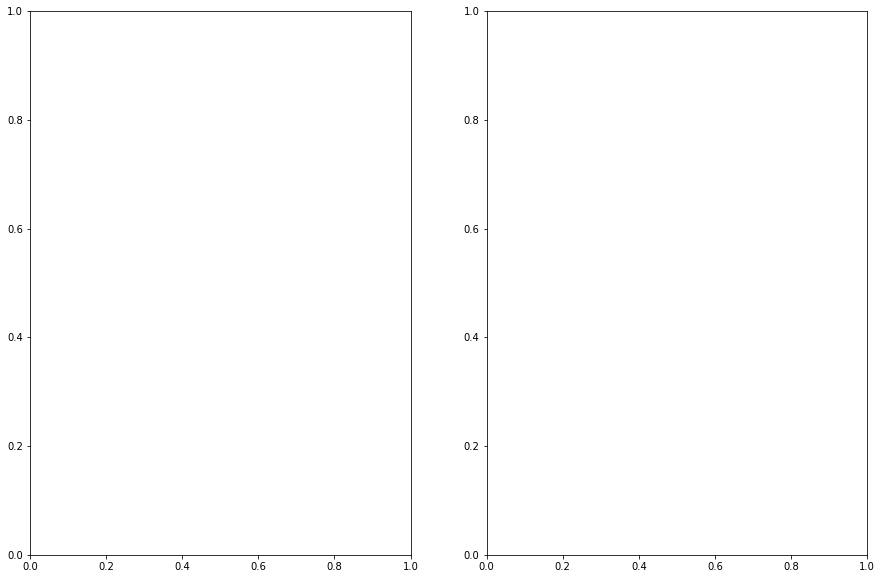

In [140]:
# Show graph

graf_model(h)
precision(modelo, True)

In [ ]:
#predicciones = modelo.predict(datos_test) #make predictions

In [ ]:
#predicciones = np.where(predicciones > 0.5, 1, 0) # prediction > 0.5 is 1, else 0
#dataframe with predictions
#submission = pd.DataFrame(predicciones,columns=['Survived'])

In [ ]:
#modelo.save('modelo90683.h5') #saving model as .h5